# Data Processiong

## Loading Data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt



In [2]:
data = pd.read_csv('data/raw_survey_data_2022.csv',header=None)

In [3]:
# with sub-questions as header
df = pd.read_csv('data/raw_survey_data_2022.csv',header=1)

## Data cleaning

In [4]:
# Check if there are invalid responses 
# 1. the response column is correct (most essential:If you have read the survey up to this point, please select the number four (4). By selecting number 4, you'll be entered to win one of the prizes.)
# 2. response time more than 200s

In [4]:
## Finding the response question and their column indices
data.loc[0,data.iloc[0,:].str.contains('If you have read the survey up to this point')==True].index

Int64Index([176, 306], dtype='int64')

In [5]:
## 1 response column is correct
df_1=df[(df.iloc[:,176]=='2')&(df.iloc[:,306]=='4')]

In [6]:
## 2 response time more than 200s
def response_time(df,minimum=200):
    data1=df.iloc[:,1] #DataFrame with start time
    data2=df.iloc[:,2] #DataFrame with end time
    data3=df.iloc[:,3:] #DataFrame with data

    data3["time"]=data2.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))-data1.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))
    #(data1.iloc[:,1].values.astype('datetime64[D]')-data1.iloc[:,0].values.astype('datetime64[D]'))

                                                                                                    
    index_time= data3["time"].apply(lambda x: x/np.timedelta64(1, 's'))
    data3['clean']=(index_time>200)
    cleaned_data=data3.loc[data3.clean==True].iloc[:,:-2]

    return cleaned_data
cleaned_data=response_time(df_1,200)

cleaned_data.shape

(1271, 348)

In [7]:
## change some answer to numerical
def numeric_scale(cleaned_data):
    for i in range(cleaned_data.shape[0]):
        for j in range(cleaned_data.shape[1]):
            if cleaned_data.iloc[i,j]=='Strongly agree':
                cleaned_data.iloc[i,j]=5
            if cleaned_data.iloc[i,j]=='Agree':
                cleaned_data.iloc[i,j]=4
            if cleaned_data.iloc[i,j]in['Neither agree or disagree','Neither agree nor disagree','Neither disagree nor agree']:
                cleaned_data.iloc[i,j]=3
            if cleaned_data.iloc[i,j]=='Disagree':
                cleaned_data.iloc[i,j]=2
            if cleaned_data.iloc[i,j]=='Strongly disagree':
                cleaned_data.iloc[i,j]=1
    return cleaned_data


cleaned_data=numeric_scale(cleaned_data)

##  Basic Statistics

In [9]:
##calculating the counts of each question

In [8]:
counts=[]
for i in range(len(cleaned_data.columns)):
    counts.append(dict(cleaned_data.iloc[:,i].value_counts()))


## Creating Question Table

In [9]:
# create the table of the first 2 rows to see the questions and the columns they locate
Q=data.iloc[:2,3:].T
Q.columns=['Question','Sub_Question']
#Q['location']=[ lambda x: x.index*(x.Question.isna()==False)]
Q=Q.reset_index(drop=True)
Q['location']=np.where(Q.Question.isna()==False, Q.Question.index, "False")
Q['counts']=counts

In [10]:
# Main questions
qq=Q[Q['location']!='False']
qq=qq.reset_index(drop=True)

In [11]:
Q.to_csv("output/Questions-22.csv", index=True)

In [12]:
pd.options.display.max_colwidth=120

In [15]:
Q.Question

0                                    I am satisfied with my overall experience at Columbia.
1      I am satisfied with the following with respect to my overall experience at Columbia.
2                                                                                       NaN
3                                                                                       NaN
4                                                                                       NaN
                                               ...                                         
343                                                                                     NaN
344                                                               What is your current age?
345                                                         Is English your first language?
346              Was English the medium of instruction in your primary or secondary school?
347           Let us know about other important matters that are not covered by 

## Find dataset for queryed text



In [13]:
##Find dataset for queryed text

def query_data(Q,qq,cleaned_data,query,indx):
    que=Q[Q['Question'].str.contains(query)==True]
    val=que.values
    ind=que.index.values
    print(Q.loc[ind[indx-1],'Question'])
    start=ind[indx-1]
    end=int(qq.iloc[qq[qq.location==str(ind[indx-1])].index+1]['location'])
    df_return=cleaned_data.iloc[:,start:end]
    return df_return



# Initial Analysis

## 1 How Satisfied are the SEAS students

In [14]:

query="satisfied"
indx=1  # the index of quetion you want to query among all questions that contains your query text, 
        # for example: I want to know the second question involves "satisfied", the indx is 2


df_satisfied = query_data(Q,qq,cleaned_data,query,indx=1)

I am satisfied with my overall experience at Columbia.


In [15]:
import matplotlib as mpl



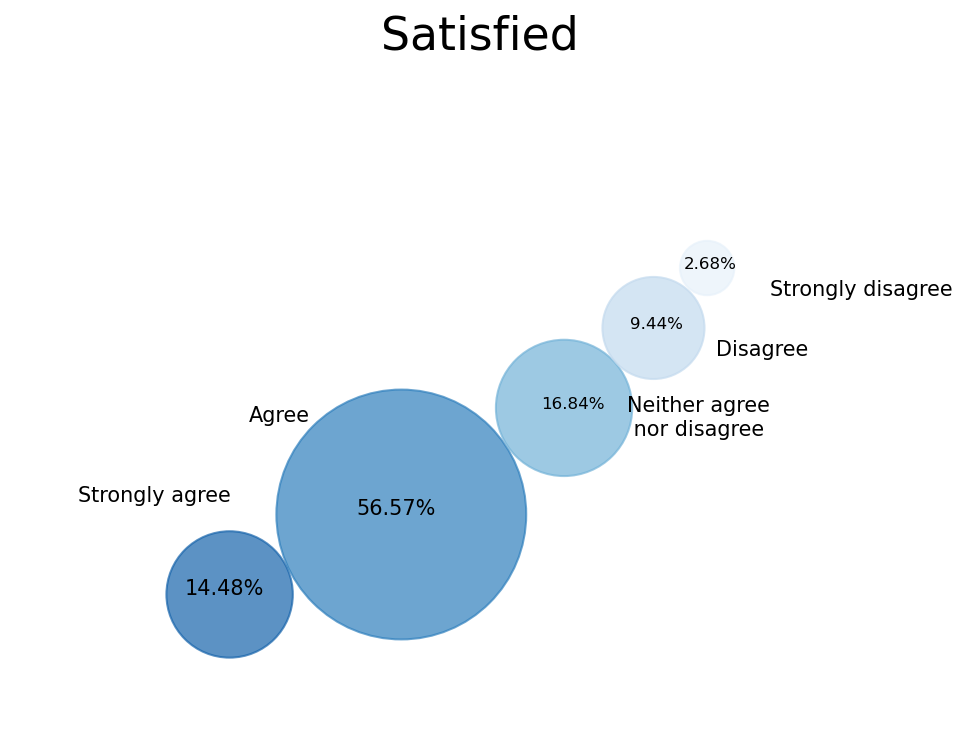

In [50]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues(np.linspace(0,0.8,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:])


indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']
a=(df_satisfied.Response.value_counts()).sort_index(ascending=False)

fig,ax0=plt.subplots(figsize=(8,6),dpi=150)

# use the scatterplot function to build the bubble map
#sns.scatterplot(x=[1,2,2.5,3,3.5], y=[0.9,1.5,1.84,1.9,2.5], size=a, legend=False, sizes=(200,20000),ax=ax0)
ax0.set_xlim([-0.2, 5.0])
ax0.set_ylim([-0.10, 5.0])
x=[1,1.96,2.87,3.37,3.67]
y=[1,1.6,2.4,3,3.45]
colors=[2.8,2.5,1.9,1.3,0.8]
sc=plt.scatter(x, y,s=a*20, c=colors, cmap=cmap,  alpha=0.7)
#plt.colorbar(sc)
for i in range(2):
    ax0.annotate(indd[i],(x[i]-0.85,y[i]+0.7))
    ax0.annotate(str(round(a[5-i]/a.sum()*100,2))+"%",(x[i]-0.25,y[i]-0))
for i in range(2,5):
    ax0.annotate(indd[i],(x[i]+0.35,y[i]-0.2))
    ax0.annotate(str(round(a[5-i]/a.sum()*100,2))+"%",(x[i]-0.13,y[i]-0),fontsize=8)
ax0.set_title("Satisfied",fontsize=22)



plt.axis('off')

# show the graph
plt.show()


## 2 Importance v.s. Satisfaction

In [16]:
df_important=query_data(Q,qq,cleaned_data,"important",indx=1)

The following are important with respect to my overall experience at Columbia.


In [17]:
df_satisfied2 = query_data(Q,qq,cleaned_data,"satisfied",indx=2)

I am satisfied with the following with respect to my overall experience at Columbia.


In [18]:
a=pd.DataFrame(df_satisfied2.mean()).T
b=pd.DataFrame(df_important.mean()).T
b.columns=a.columns
c2022=pd.concat([a,b],ignore_index=True)
c2022['Year']=2022

In [19]:
data_2019 = pd.read_csv('data/Copy of de-identified Graduate Student Quality of Life Survey - Spring 2019.xlsx - Graduate Student Quality of Lif.csv',header=1)

In [20]:
# use the same way to clean 2019 data
print(data_2019.shape)
cleaned_data_2019=response_time(data_2019,200)
cleaned_data_2019.shape

(1033, 345)


(997, 342)

In [21]:

d2019=numeric_scale(cleaned_data_2019)

In [22]:

df_satisfied2019=query_data(Q,qq,d2019,"satisfied",indx=2)
df_important2019=query_data(Q,qq,d2019,"important",indx=1)

I am satisfied with the following with respect to my overall experience at Columbia.
The following are important with respect to my overall experience at Columbia.


In [23]:
aa=pd.DataFrame(df_satisfied2019.mean()).T
bb=pd.DataFrame(df_important2019.mean()).T
bb.columns=aa.columns

c2019=pd.concat([aa,bb],ignore_index=True)
c2019['Year']=2019


In [24]:
c2019.columns=c2022.columns
cc=pd.concat([c2019,c2022],ignore_index=True)
cc

Academics  Mental health  Physical health  Professional development  \
0   3.993982       3.579739         3.669007                  3.839519   
1   4.538616       4.169509         4.183551                  4.324975   
2   3.883556       3.430370         3.530291                  3.675846   
3   4.597168       4.289536         4.210071                  4.332809   

   Social life  Career Placement Team   Housing  \
0     3.641926               3.648947  3.236710   
1     3.998997               4.299900  3.863591   
2     3.536585               3.260425  3.235248   
3     4.143981               4.274587  3.901652   

   Intercampus Shuttle/Via Service  Library services  Funding opportunities  \
0                         3.502508          4.125376               3.184554   
1                         3.304915          4.131394               3.953862   
2                         3.653029          4.084186               3.024390   
3                         3.804878          4.047994               4.009441   

   Student life and academic advising  Technology services and support  Year  
0                            3.744233                         3.898696  2019  
1                            4.248746                         4.056169  2019  
2                            3.484658                         3.713611  2022  
3                            4.313139                         3.985051  2022

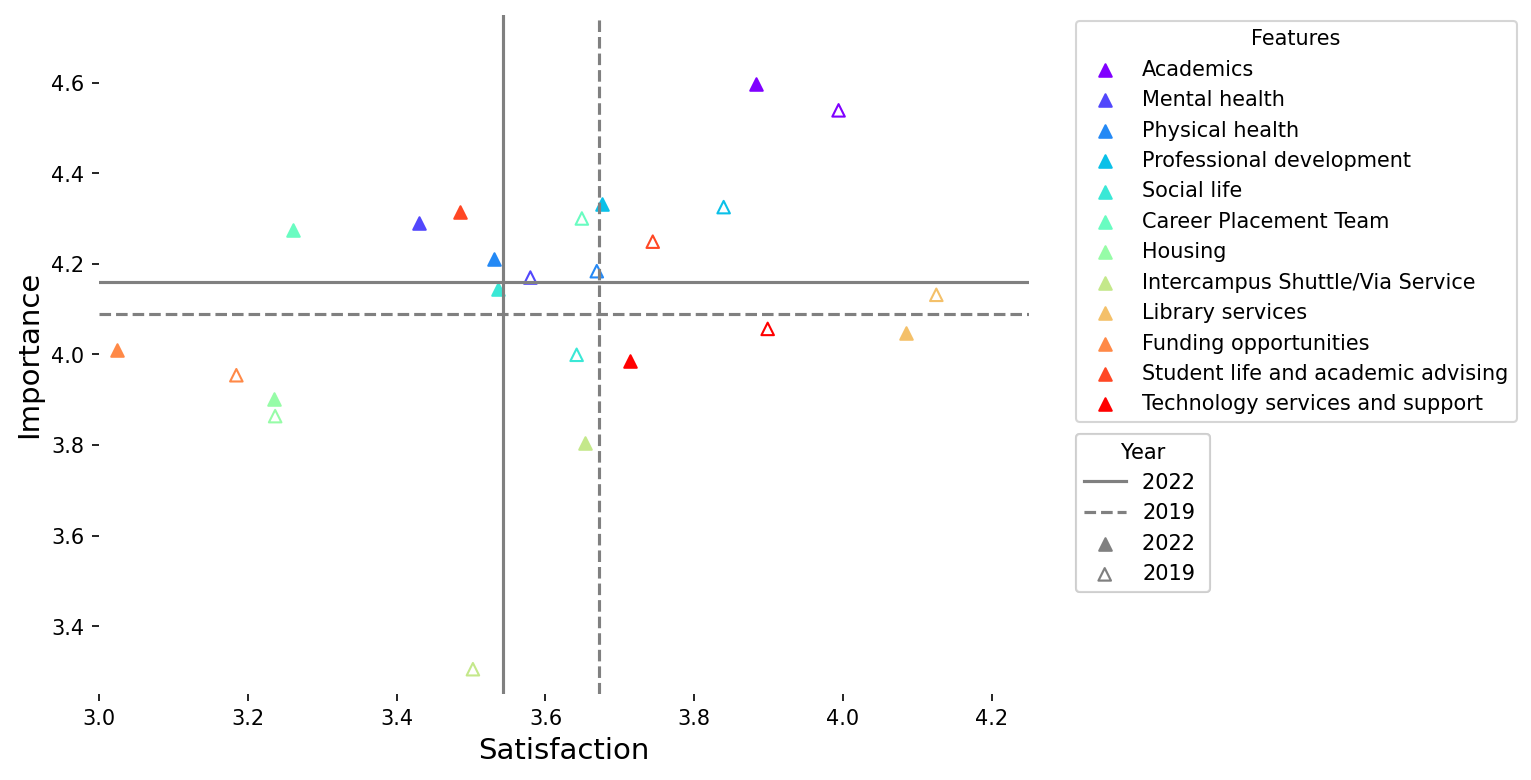

In [36]:
#plt.scatter(c.iloc[0,:],c.iloc[1,:])
import matplotlib.cm as cm


fig,ax=plt.subplots(figsize=(8,6),dpi=150)


colors = cm.rainbow(np.linspace(0, 1, (12)))

for i in range(12):
    ax.scatter(c2022.iloc[0,i], c2022.iloc[1,i],marker='^',label=c2022.columns[i],c=colors[i].reshape(1,-1))

for i in range(12):
    ax.scatter(c2019.iloc[0,i], c2019.iloc[1,i],marker='^',facecolors='none',edgecolors=colors[i].reshape(1,-1))

line1=ax.axhline(y=c2022.iloc[1,:-1].mean(),c='grey')
ax.axvline(x=c2022.iloc[0,:-1].mean(),c='grey' )

line2=ax.axhline(y=c2019.iloc[1,:-1].mean(),c='grey',ls='--')
ax.axvline(x=c2019.iloc[0,:-1].mean(),c='grey' ,ls='--')


ax.set_xlim([3.0, 4.250])
ax.set_ylim([3.25, 4.750])


#ax.set_title("Importance vs Satisfaction for all features",fontsize=22)


#second_legend=plt.legend(c.columns,bbox_to_anchor=(1, 2.5))
#second_legend=plt.legend(c.columns,loc="upper left")

leg = plt.legend(loc=(1.05,0.4), title="Features")
ax.add_artist(leg)
#leg = plt.legend(,loc=(1.05,0.4), title="Year")


#import matplotlib.lines as mlines

import matplotlib.patches as mpatches

grey_triangle1 = ax.scatter([], [], color='grey', marker='^', linestyle='None')
grey_triangle2 = ax.scatter([], [], color='grey', marker='^', facecolors='none',edgecolors="grey",linestyle='None')

#first_legend=plt.legend([line1,line2],['2022','2019'],bbox_to_anchor=(1, 1.05))
leg1=plt.legend(handles=[line1,line2,grey_triangle1,grey_triangle2], labels=['2022 ','2019','2022 ','2019'],loc=(1.05,0.15), title="Year")
ax.add_artist(leg1)

ax.set_xlabel("Satisfaction",fontsize=14)
ax.set_ylabel("Importance",fontsize=14)

#for i,txt in enumerate(np.arange(12)):
 #   print(i,txt)
    #ax.annotate(txt,(c.columns[i]))
#for i in range(6,10):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i], c2022.iloc[1,i]))
#for i in range(0,2):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]+0.02, c2022.iloc[1,i]-0.035))
#for i in range(3,5):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]+0.02, c2022.iloc[1,i]-0.035))
#for i in range(2,3):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.38, c2022.iloc[1,i]-0.035))
#for i in range(5,6):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.28, c2022.iloc[1,i]-0.05))
#for i in range(10,11):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.48, c2022.iloc[1,i]+0.1))
#for i in range(11,12):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i], c2022.iloc[1,i]-0.05))
    
ax.axhline(y=c2022.iloc[1,:].mean())
ax.axvline(x=c2022.iloc[0,:].mean(),c='black' )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.show()





## 3 Satisfaction on other basis

In [39]:
degree=query_data(Q,qq,cleaned_data,'Current Academic Program',indx=1)
department=query_data(Q,qq,cleaned_data,'current academic department',indx=1)
gender=query_data(Q,qq,cleaned_data,'gender',indx=3)
LGBTQ=query_data(Q,qq,cleaned_data,'LGBTQ',indx=1)
ethnic=query_data(Q,qq,cleaned_data,'ethnic',indx=1)
country=query_data(Q,qq,cleaned_data,'Country',indx=1)
age=query_data(Q,qq,cleaned_data,'age',indx=3)

Current Academic Program
What is your current academic department or institute?
Please indicate the gender(s) with which you identify (check all that apply):
Do you identify yourself as part of the LGBTQ community?
Please identify your ethnic background.
Country of Origin
What is your current age?


In [53]:
inddf=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Not Applicable']

## Satisfation by Gender

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


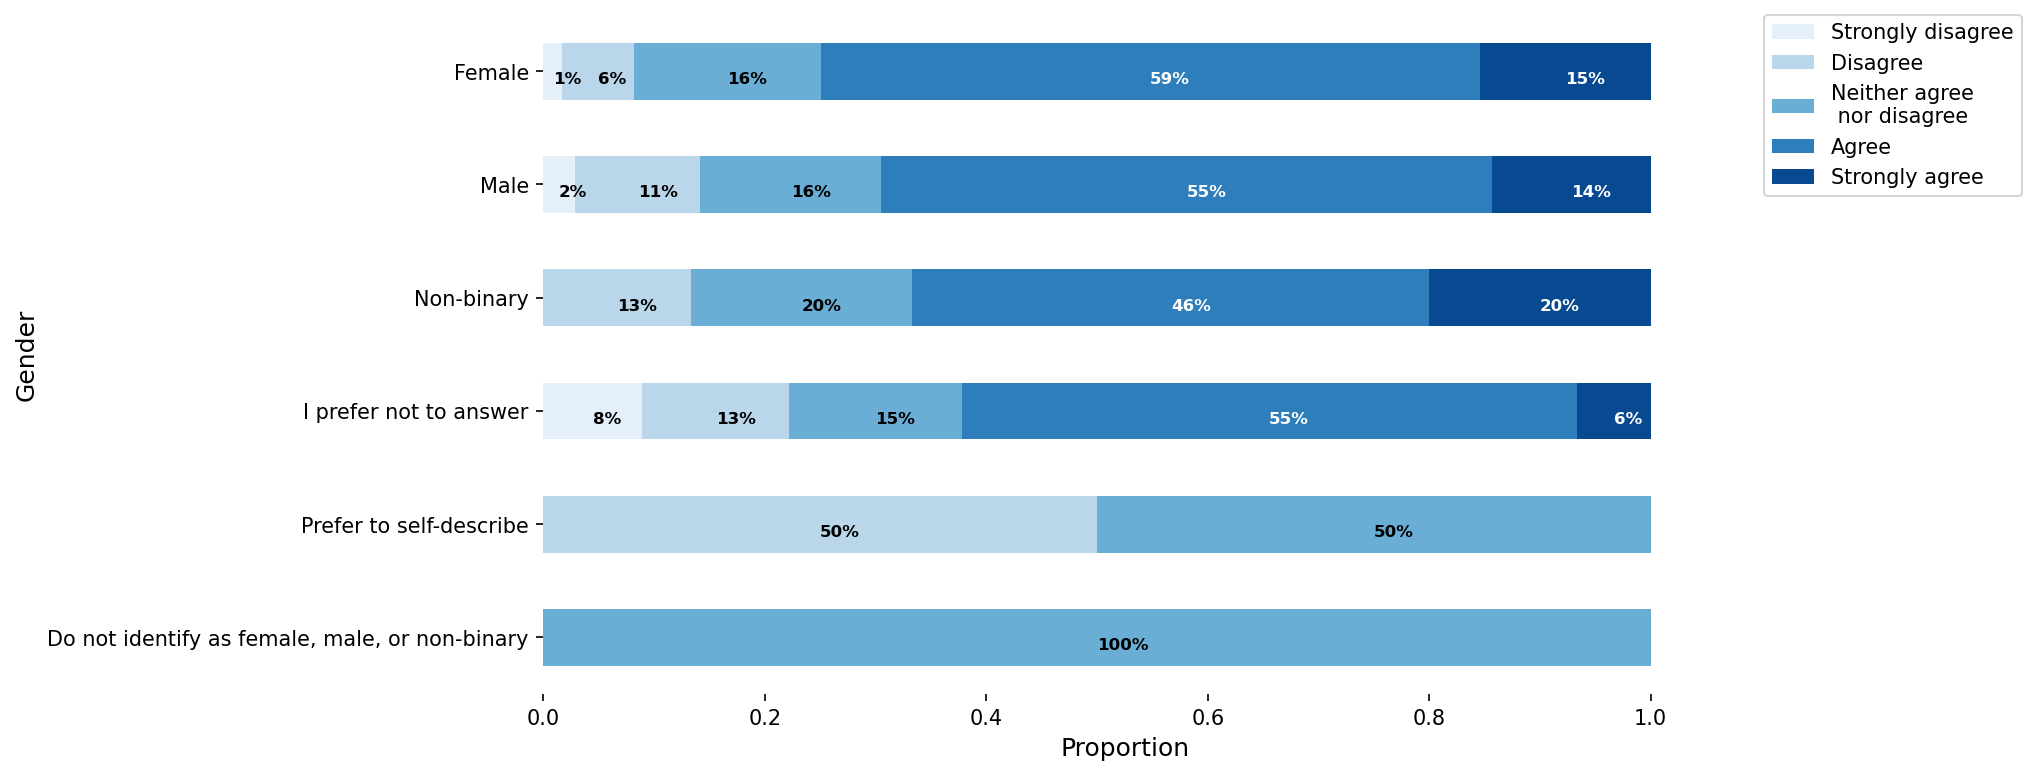

In [70]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


df_satisfied_gender=df_satisfied.copy()
df_satisfied_gender=df_satisfied_gender.join(gender)

gender_c=['Female','Male','Response','Non-binary','Do not identify as female, male, or non-binary','I prefer not to answer','Prefer to self-describe']
b=pd.DataFrame(columns=gender_c) 
for i in gender_c:
    data_used=df_satisfied_gender.loc[df_satisfied_gender[i].isna()!=True,'Response']
    b[i]=(pd.DataFrame(data_used.value_counts()).fillna(0)/pd.DataFrame(data_used).count(axis=0)*100)
    #print(pd.DataFrame(data_used).count(axis=0))  
 #b.append(a)

#b=b[b.columns[::-1]]
b=b[['Female', 'Male', 'Non-binary','I prefer not to answer', 'Prefer to self-describe','Do not identify as female, male, or non-binary'][::-1]]
b_prob=b.apply(lambda x: x / x.sum(), axis=0)
aaa=b.sort_index().T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(inddf[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Gender",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Gender",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}%', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}%', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## Satisfaction By Degree

In [40]:
df_satisfied_degree=df_satisfied.copy()
df_satisfied_degree['degree']=degree
df_satisfied_degree['num']=1
dff=df_satisfied_degree.groupby(['degree','Response']).count().unstack('degree')
df_degree=dff['num']#/dfff.sum(axis=0)
#dff.to_csv("output/df_satisfied_degree.csv")
#df_degree=dff['num'].drop(columns='Professional Degree')
df_degree=df_degree.fillna(0)
#df_satisfied_degrea['Response']=df_satisfied_degree.Response.astype(int)
inner=df_satisfied_degree.groupby(['degree','Response']).sum()
outer = df_satisfied_degree.groupby('degree').sum()
outer

num
degree                           
Doctor of Philosophy (Ph.D.)  208
M.S. leading to Ph.D.          74
Master of Science (M.S.)      988
Professional Degree             1

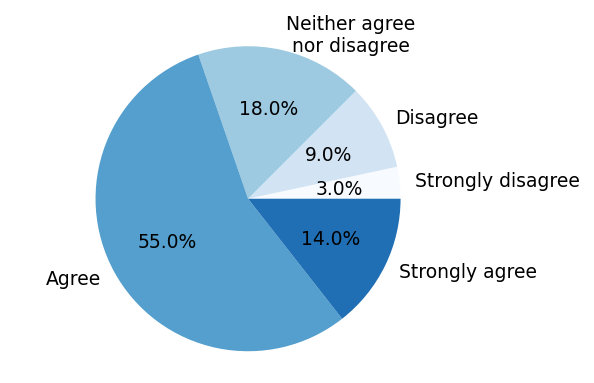

In [65]:
# Create a pieplot
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']


fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
cmap = mpl.cm.Blues(np.linspace(0,1.7,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

explode = (0, 0, 0, 0,0) 
_, _, autotexts =ax.pie(df_degree['Doctor of Philosophy (Ph.D.)'], explode=explode, labels=indd[::-1], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmap,
        shadow=False,textprops={'fontsize':9})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


posx and posy should be finite values
posx and posy should be finite values


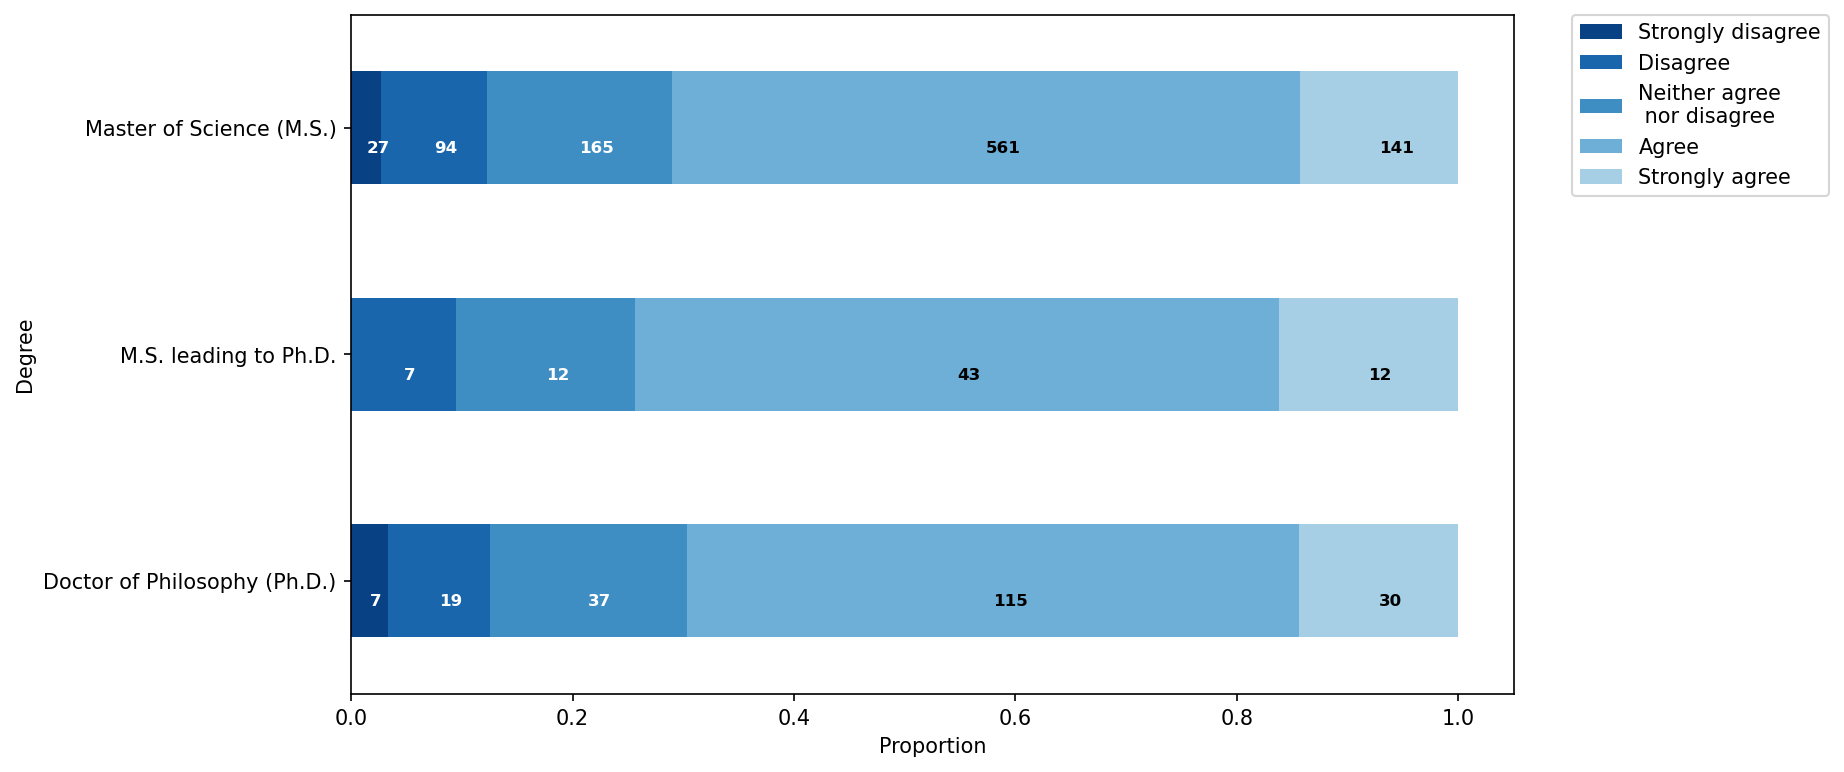

In [142]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


b_prob=df_degree.apply(lambda x: x / x.sum(), axis=0)
aaa=df_degree.T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Degree")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

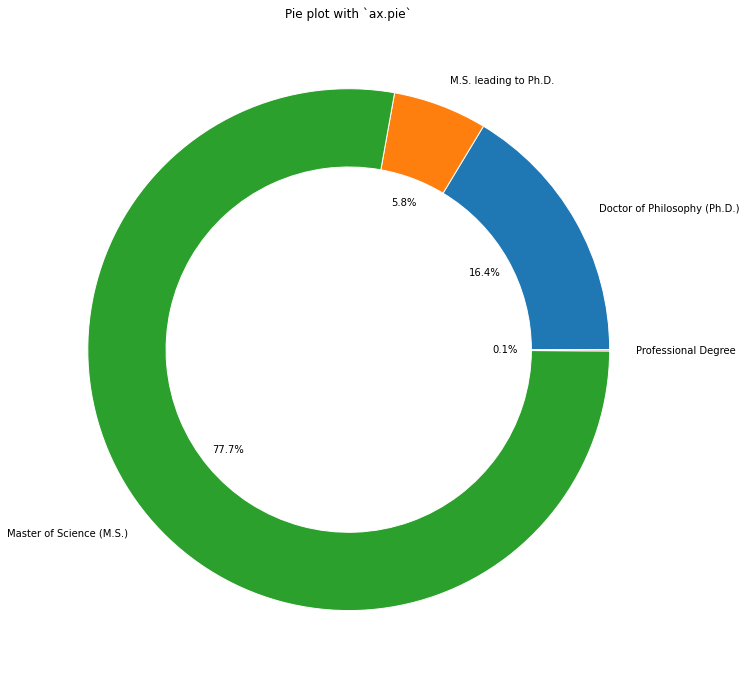

In [335]:
fig, ax = plt.subplots(figsize=(24,12))
size = 0.3

ax.pie(outer.values.flatten(), radius=1,
       labels=outer.index,
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

#ax.pie(inner.values.flatten(), radius=1-size, 
#       labels = inner_labels,
#       wedgeprops=dict(width=size, edgecolor='w'),colors=cmap)

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

## Satisfaction by Department

In [68]:
department.replace('Data Science Institute', 'Data Science (MS Only)',inplace=True)

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/3801099888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  department.replace('Data Science Institute', 'Data Science (MS Only)',inplace=True)


In [85]:
(b_prob.iloc[3:,:].sum()).sort_values()

department
I prefer not to answer.                           0.555556
Earth and Environmental Engineering               0.586207
Computer Science                                  0.664234
Data Science (MS Only)                            0.697368
Industrial Engineering and Operations Research    0.700637
Electrical Engineering                            0.709459
Biomedical Engineering                            0.739130
Applied Physics and Applied Mathematics           0.741379
Mechanical Engineering                            0.747368
Civil Engineering and Engineering Mechanics       0.790323
Chemical Engineering                              0.823529
dtype: float64

In [87]:
b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index]

department  I prefer not to answer.  Earth and Environmental Engineering  \
Response                                                                   
1                               NaN                             0.068966   
2                          0.222222                             0.172414   
3                          0.222222                             0.172414   
4                          0.333333                             0.413793   
5                          0.222222                             0.172414   

department  Computer Science  Data Science (MS Only)  \
Response                                               
1                   0.032847                0.039474   
2                   0.116788                0.131579   
3                   0.186131                0.131579   
4                   0.547445                0.605263   
5                   0.116788                0.092105   

department  Industrial Engineering and Operations Research  \
Response                                                     
1                                                 0.015924   
2                                                 0.105096   
3                                                 0.178344   
4                                                 0.566879   
5                                                 0.133758   

department  Electrical Engineering  Biomedical Engineering  \
Response                                                     
1                         0.027027                0.036232   
2                         0.074324                0.065217   
3                         0.189189                0.159420   
4                         0.527027                0.579710   
5                         0.182432                0.159420   

department  Applied Physics and Applied Mathematics  Mechanical Engineering  \
Response                                                                      
1                                          0.034483                0.010526   
2                                          0.086207                0.073684   
3                                          0.137931                0.168421   
4                                          0.637931                0.621053   
5                                          0.103448                0.126316   

department  Civil Engineering and Engineering Mechanics  Chemical Engineering  
Response                                                                       
1                                              0.032258              0.014706  
2                                              0.048387              0.044118  
3                                              0.129032              0.117647  
4                                              0.580645              0.588235  
5                                              0.209677              0.235294

posx and posy should be finite values
posx and posy should be finite values


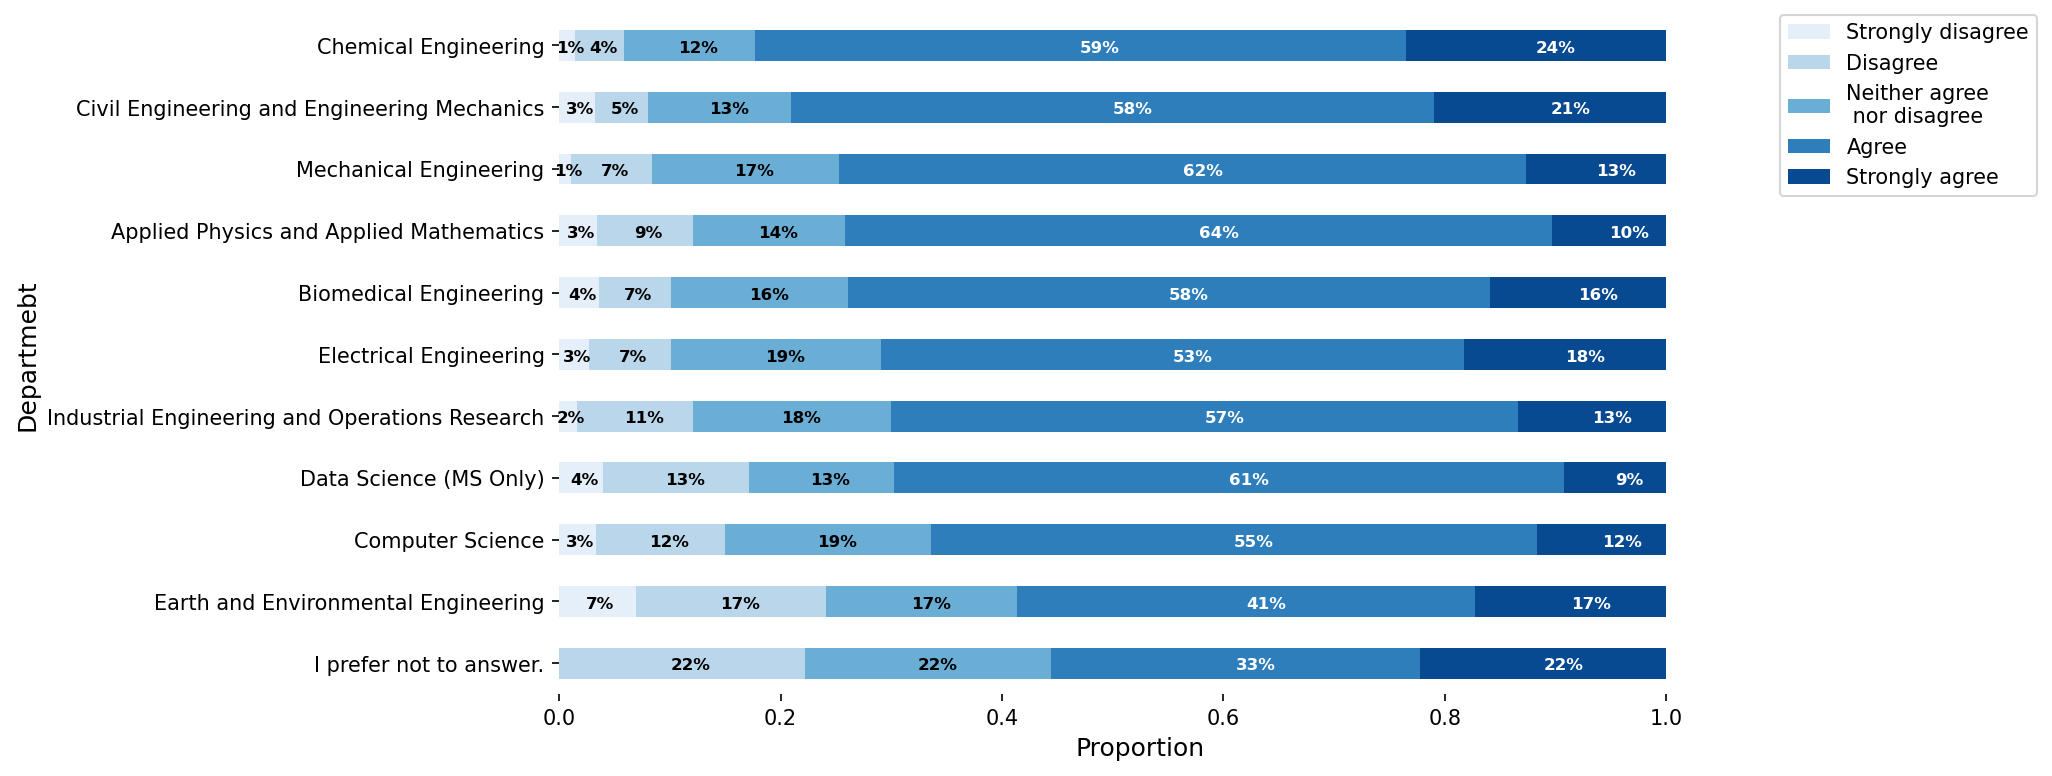

In [91]:
#cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

df_satisfied_department=df_satisfied.copy()
df_satisfied_department['department']=department
df_satisfied_department['num']=1
b=df_satisfied_department.groupby(['department','Response']).count().unstack('department').num
#/dfff.sum(axis=0)
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']


#cm = plt.cm.get_cmap('RdYlBu')
#b=b_prob[(b_prob.iloc[4:,:].sum()).sort_values().index]
b_prob=b.apply(lambda x: x / x.sum(), axis=0)
aaa=b[(b_prob.iloc[3:,:].sum()).sort_values().index].T
bbb=b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index].T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
bbb.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Departmebt",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Gender",fontsize=20)



for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## Academics


In [92]:
aca_import=query_data(Q,qq,cleaned_data,"academics",indx=1)


The following are important with respect to my overall satisfaction with SEAS classes and academics.


In [107]:
aca_import[aca_import.mean().sort_values().index].mean()

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2793828889.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  aca_import[aca_import.mean().sort_values().index].mean()


Supplementary educational tools    3.906373
Degree requirements                4.009441
Course Delivery Method             4.226593
Instruction                        4.366640
Course content                     4.408340
dtype: float64

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1405561428.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=pd.DataFrame((aca_import[aca_import.mean().sort_values().index[::-1]].mean()))


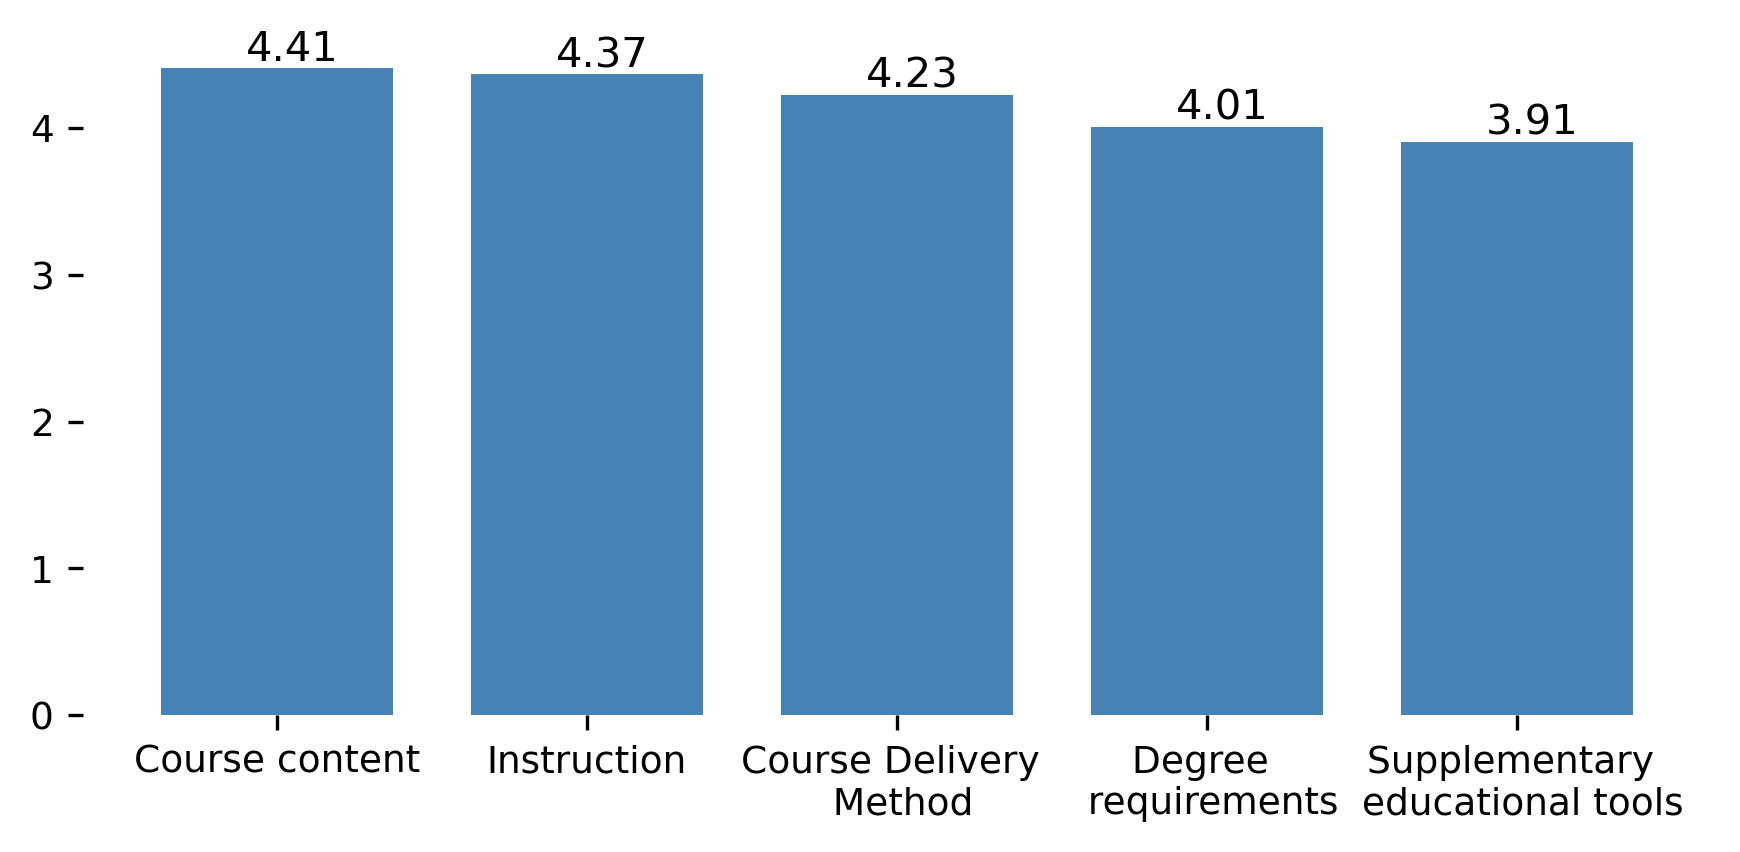

In [118]:


fig,ax=plt.subplots(figsize=(7,3),dpi=300)
#aca_import['degree']=degree
#df=aca_import.groupby(['degree']).mean().drop(index='Professional Degree')
#df=df[df.sum().sort_values().index]
indd=['Supplementary \n educational tools', 'Degree \n requirements',
       'Course Delivery \n Method', 'Instruction', 'Course content']
df=pd.DataFrame((aca_import[aca_import.mean().sort_values().index[::-1]].mean()))
ax=df.plot.bar(ax=ax,color='steelblue',width=0.75, rot=0 ,fontsize=9,legend=None)
#ax=plt.bar(np.arange(0,5,1),(aca_import[aca_import.mean().sort_values().index[::-1]].mean()),color='steelblue',width=0.75)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.set_xticklabels(indd[::-1], rotation=0,)
x_offset = -0.1
y_offset = 0.05
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2376935726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aca_import['degree']=degree


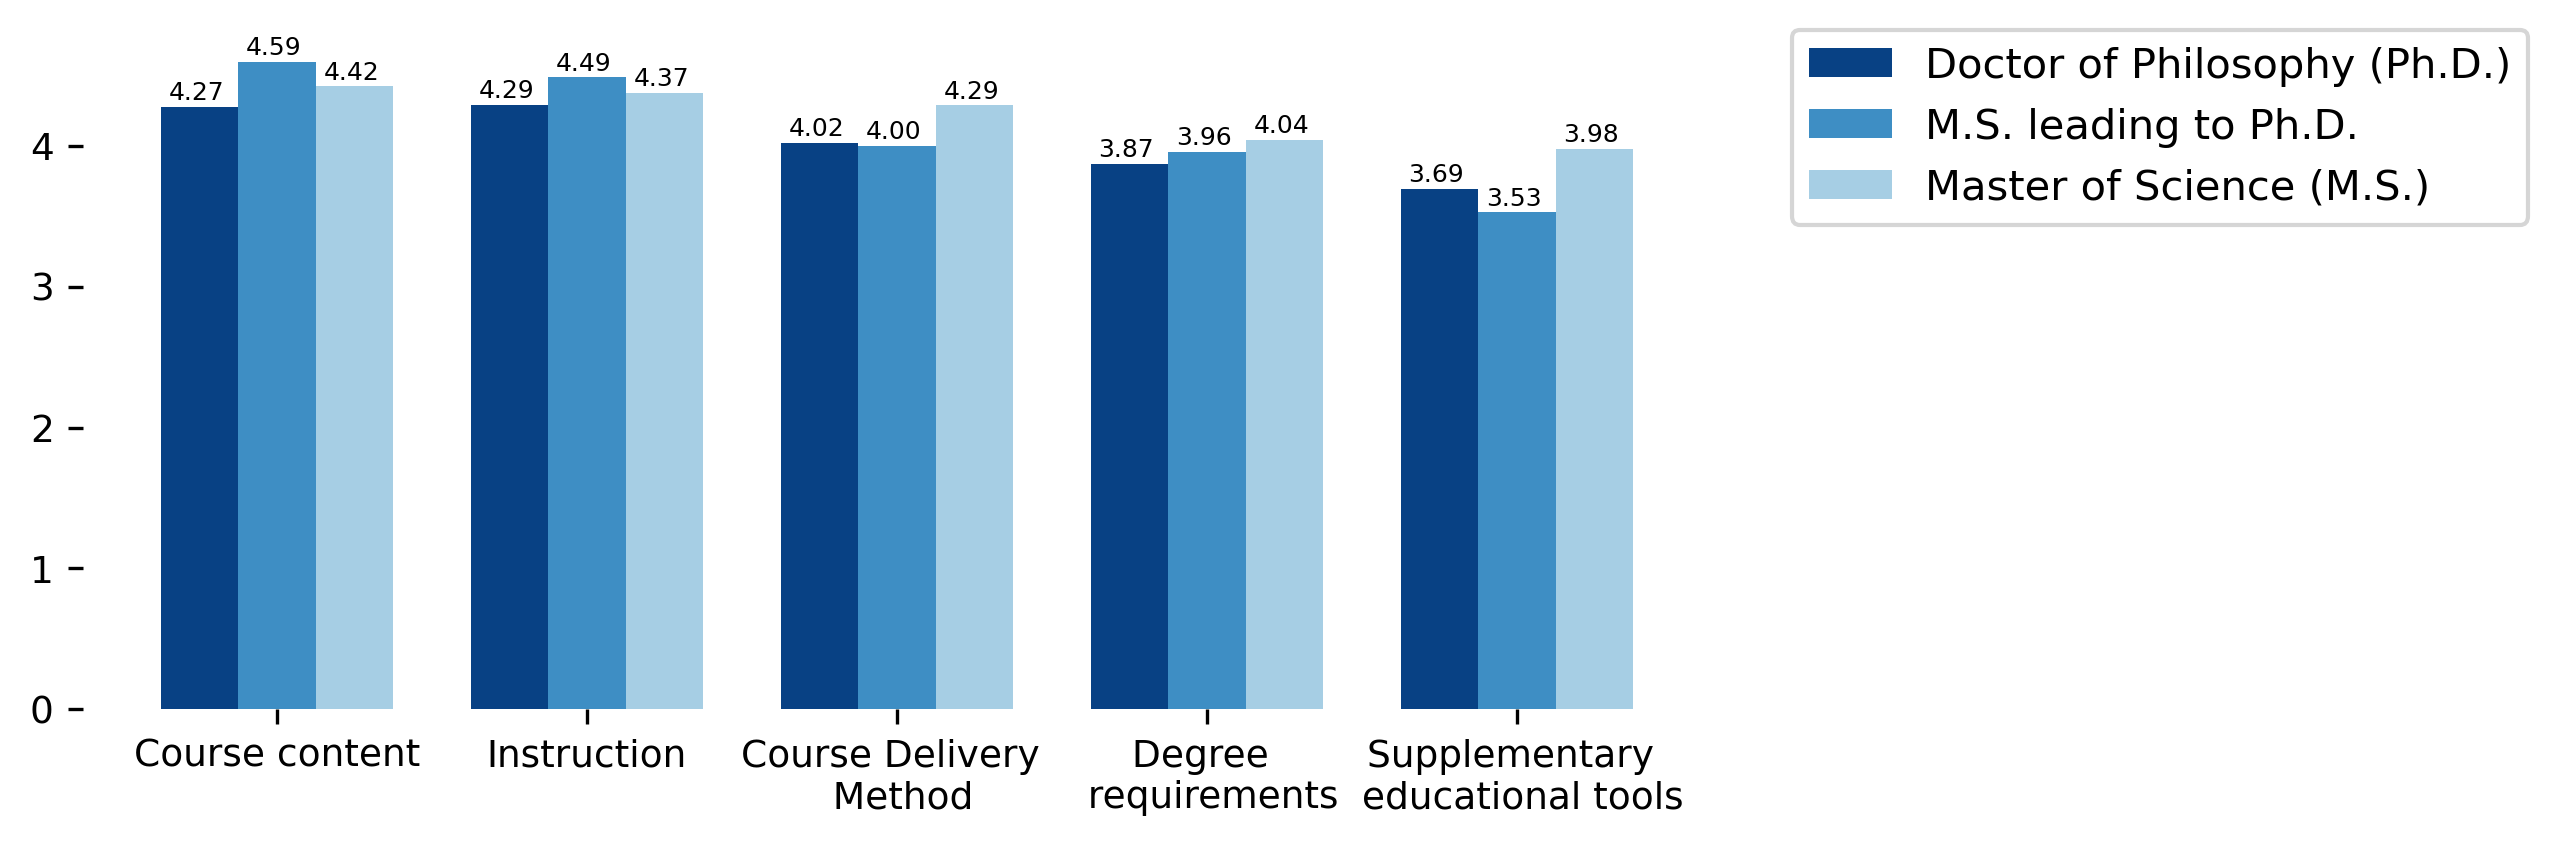

In [131]:
cmapr = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmapr = mpl.colors.ListedColormap(cmapr[10:,:-1])


fig,ax=plt.subplots(figsize=(7,3),dpi=300)
aca_import['degree']=degree
df=aca_import.groupby(['degree']).mean().drop(index='Professional Degree')
df=df[df.sum().sort_values().index[::-1]]
indd=['Supplementary \n educational tools', 'Degree \n requirements',
       'Course Delivery \n Method', 'Instruction', 'Course content']
ax=df.T.plot.bar(ax=ax,colormap=cmapr,width=0.75, rot=0 ,fontsize=9)
ax.set_xticklabels(indd[::-1], rotation=0,)
x_offset = -0.1
y_offset = 0.05
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [160]:
aca=query_data(Q,qq,cleaned_data,"academics",indx=2)

Please answer the following with respect to SEAS classes and academics.


In [179]:
aca1=pd.DataFrame(aca['The overall teaching quality of the lecturer was satisfactory:'].replace('Not Applicable',0))
aca1['dep']=department
aca1['degree']=degree
#aca1['num']=1
aca1['The overall teaching quality of the lecturer was satisfactory:'].replace(4,5,inplace=True)
aca1['The overall teaching quality of the lecturer was satisfactory:'].replace(2,1,inplace=True)


In [191]:
daca1=aca1.groupby(['dep','The overall teaching quality of the lecturer was satisfactory:']).count().unstack('dep').degree

In [192]:
daca1.drop(index=0,columns='I prefer not to answer.',inplace=True)
daca1

dep                                                             Applied Physics and Applied Mathematics  \
The overall teaching quality of the lecturer was satisfactory:                                            
1                                                                                                   3.0   
3                                                                                                   9.0   
5                                                                                                  46.0   

dep                                                             Biomedical Engineering  \
The overall teaching quality of the lecturer was satisfactory:                           
1                                                                                 15.0   
3                                                                                 18.0   
5                                                                                103.0   

dep                                                             Chemical Engineering  \
The overall teaching quality of the lecturer was satisfactory:                         
1                                                                                4.0   
3                                                                               15.0   
5                                                                               49.0   

dep                                                             Civil Engineering and Engineering Mechanics  \
The overall teaching quality of the lecturer was satisfactory:                                                
1                                                                                                       4.0   
3                                                                                                      11.0   
5                                                                                                      47.0   

dep                                                             Computer Science  \
The overall teaching quality of the lecturer was satisfactory:                     
1                                                                           16.0   
3                                                                           37.0   
5                                                                          214.0   

dep                                                             Data Science (MS Only)  \
The overall teaching quality of the lecturer was satisfactory:                           
1                                                                                 13.0   
3                                                                                 10.0   
5                                                                                 53.0   

dep                                                             Earth and Environmental Engineering  \
The overall teaching quality of the lecturer was satisfactory:                                        
1                                                                                               6.0   
3                                                                                               4.0   
5                                                                                              19.0   

dep                                                             Electrical Engineering  \
The overall teaching quality of the lecturer was satisfactory:                           
1                                                                                 15.0   
3                                                                                 20.0   
5                                                                                109.0   

dep                                                             Industrial Engineering and Operations Research  \
The overall teaching quality of the lecturer was satisfactory: 

In [193]:
ind3=['Agree','Neither agree \n nor disagree','Disagree']

b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]

dep                                                             Earth and Environmental Engineering  \
The overall teaching quality of the lecturer was satisfactory:                                        
1                                                                                          0.206897   
3                                                                                          0.137931   
5                                                                                          0.655172   

dep                                                             I prefer not to answer.  \
The overall teaching quality of the lecturer was satisfactory:                            
1                                                                              0.111111   
3                                                                              0.222222   
5                                                                              0.666667   

dep                                                             Data Science (MS Only)  \
The overall teaching quality of the lecturer was satisfactory:                           
1                                                                             0.171053   
3                                                                             0.131579   
5                                                                             0.697368   

dep                                                             Chemical Engineering  \
The overall teaching quality of the lecturer was satisfactory:                         
1                                                                           0.058824   
3                                                                           0.220588   
5                                                                           0.720588   

dep                                                             Electrical Engineering  \
The overall teaching quality of the lecturer was satisfactory:                           
1                                                                             0.104167   
3                                                                             0.138889   
5                                                                             0.756944   

dep                                                             Biomedical Engineering  \
The overall teaching quality of the lecturer was satisfactory:                           
1                                                                             0.110294   
3                                                                             0.132353   
5                                                                             0.757353   

dep                                                             Civil Engineering and Engineering Mechanics  \
The overall teaching quality of the lecturer was satisfactory:                                                
1                                                                                                  0.064516   
3                                                                                                  0.177419   
5                                                                                                  0.758065   

dep                                                             Applied Physics and Applied Mathematics  \
The overall teaching quality of the lecturer was satisfactory:                                            
1                                                                                              0.051724   
3                                                                                              0.155172   
5                                                                                              0.793103   

dep                                                             Computer Science  \
The overall teaching quality of the lecturer was satisfact

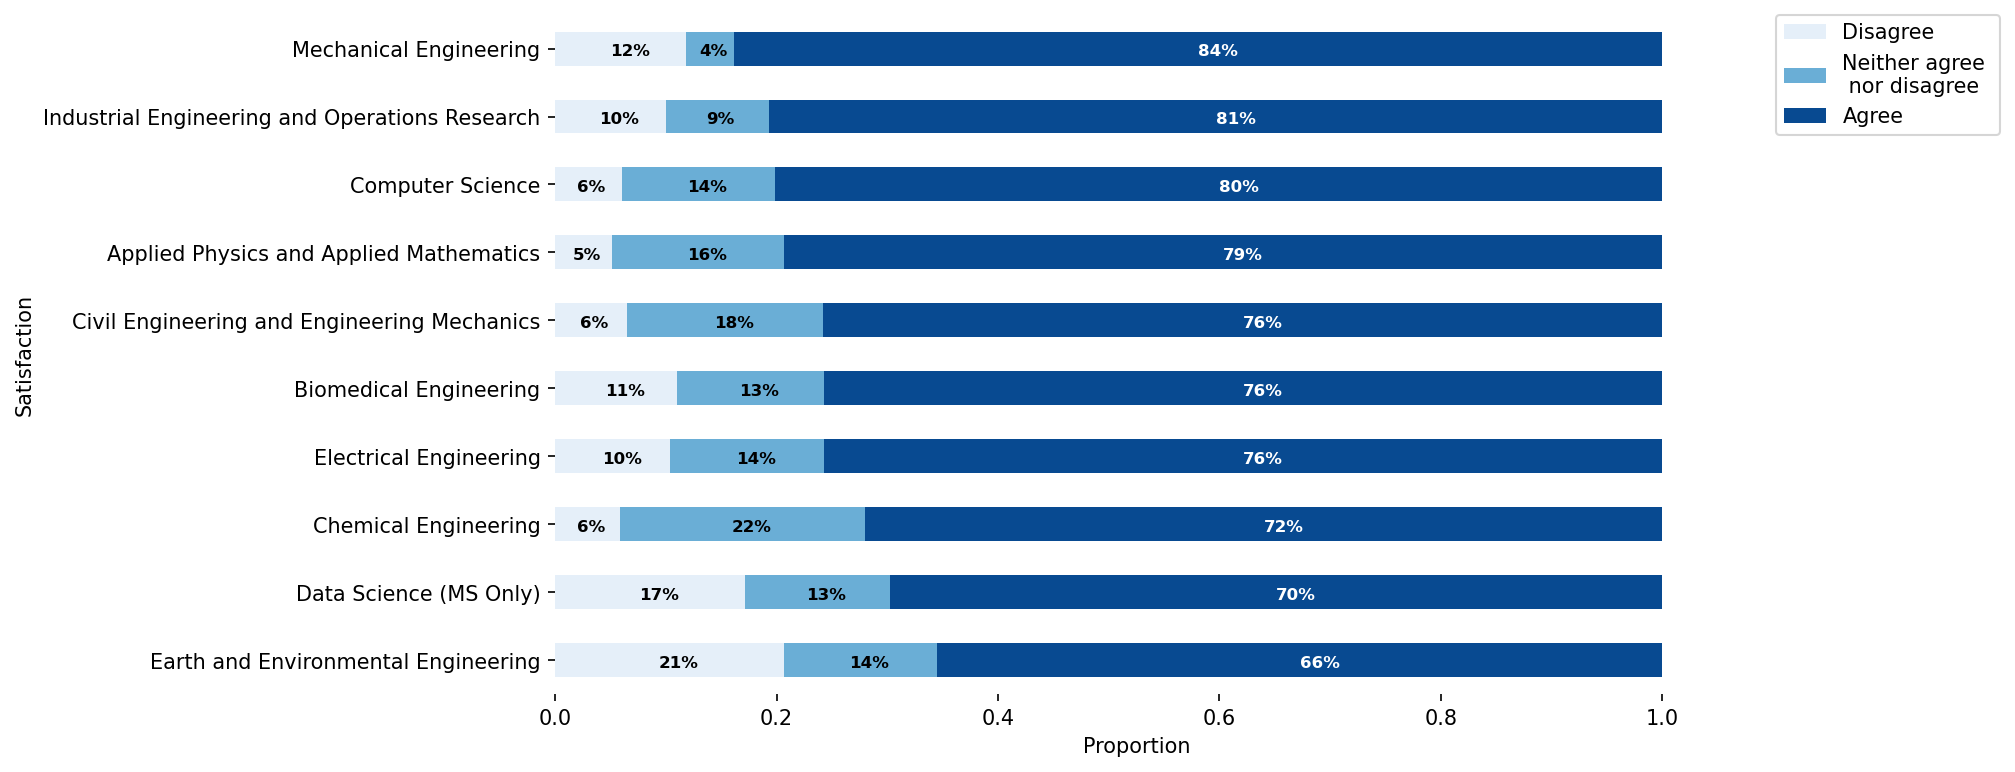

In [194]:
cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])



b_prob=(daca1[(daca1.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
b_prob=b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]
aaa=(b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]).T
bbb=b_prob.T

fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind3[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Satisfaction")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
            if count>0.02:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## PDL

In [152]:
PDL_sat=query_data(Q,qq,cleaned_data,"satisfied",indx=3)
PDL_sat.value_counts()

I am satisfied with the PDL Core Modules.


Response.6
4             512
5             213
3             137
2              69
1              42
dtype: int64

In [936]:
PDL=query_data(Q,qq,cleaned_data,"PDL",indx=1)
PDL.value_counts()

Did you attend the Professional Development and Leadership (PDL) Program?


Response.5
Yes           973
No             15
dtype: int64

In [942]:
PDL['department']=department
PDL['num']=1
pdl_dep=PDL.groupby(['department','Response.5']).sum().unstack('department')


In [943]:
pdl_dep

num                         \
department Applied Physics and Applied Mathematics Biomedical Engineering   
Response.5                                                                  
No                                             NaN                    1.0   
Yes                                           26.0                   73.0   

                                                                             \
department Chemical Engineering Civil Engineering and Engineering Mechanics   
Response.5                                                                    
No                          NaN                                         3.0   
Yes                        40.0                                        50.0   

                                                    \
department Computer Science Data Science Institute   
Response.5                                           
No                      7.0                    1.0   
Yes                   229.0                   75.0   

                                                                       \
department Earth and Environmental Engineering Electrical Engineering   
Response.5                                                              
No                                         NaN                    NaN   
Yes                                       13.0                  106.0   

                                    \
department I prefer not to answer.   
Response.5                           
No                             NaN   
Yes                            5.0   

                                                           \
department Industrial Engineering and Operations Research   
Response.5                                                  
No                                                    NaN   
Yes                                                 297.0   

                                   
department Mechanical Engineering  
Response.5                         
No                            3.0  
Yes                          59.0

In [150]:
PDLe_sat=query_data(Q,qq,cleaned_data,"PDL",indx=3)
PDLe_sat.value_counts().sum()

I am satisfied with the PDL Elective Modules.


973

In [324]:
df_satisfied_department=df_satisfied.copy()
df_satisfied_department['department']=department
df_satisfied_department['num']=1
dff=df_satisfied_department.groupby(['department','Response']).count().unstack('department')
#/dfff.sum(axis=0)
inddd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Unaware of this resource']



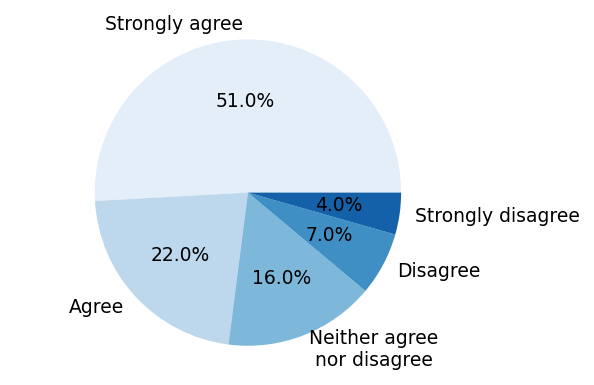

In [159]:
fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
#cmap = mpl.cm.Blues(np.linspace(0,1.5,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
cmapp = mpl.cm.Blues(np.linspace(0.1,1.7,10))
explode = (0, 0, 0, 0,0) 
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']
_, _, autotexts =ax.pie(PDLe_sat.value_counts(), explode=explode, labels=indd, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmapp,
        shadow=False,textprops={'fontsize': 9})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#


#fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)

#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

#explode = (0, 0, 0, 0,0) 
#_, _, autotexts =ax.pie(df_degree['Doctor of Philosophy (Ph.D.)'], explode=explode, labels=indd[::-1], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmap,
#        shadow=False,textprops={'fontsize':9})
#ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The level of mentorship and guidance provided by my advisor(s) is adequate:

In [951]:
query_data(Q,qq,cleaned_data,"advisor",indx=2)

I am satisfied with my advisor's ability to:


Communicate efficiently Transfer academic knowledge  \
0                          5                           5   
2                          4                           4   
5             Not Applicable              Not Applicable   
6                          3                           3   
7                          4              Not Applicable   
...                      ...                         ...   
1585          Not Applicable              Not Applicable   
1586                       5                           5   
1587                       2                           2   
1588                       5                           5   
1590          Not Applicable              Not Applicable   

     Manage my research group  \
0                           3   
2                           3   
5              Not Applicable   
6                           3   
7              Not Applicable   
...                       ...   
1585           Not Applicable   
1586                        5   
1587                        3   
1588                        5   
1590           Not Applicable   

     Create a supportive and collaborative research environment  \
0                                                             3   
2                                                             3   
5                                                Not Applicable   
6                                                             3   
7                                                             4   
...                                                         ...   
1585                                             Not Applicable   
1586                                                          5   
1587                                                          4   
1588                                                          5   
1590                                             Not Applicable   

     Provide financial support for conferences of my interest  \
0                                                           3   
2                                              Not Applicable   
5                                              Not Applicable   
6                                                           3   
7                                              Not Applicable   
...                                                       ...   
1585                                           Not Applicable   
1586                                                        5   
1587                                                        1   
1588                                                        5   
1590                                           Not Applicable   

     Provide career guidance and support  
0                                      4  
2                         Not Applicable  
5                         Not Applicable  
6                                      3  
7                         Not Applicable  
...                                  ...  
1585                      Not Applicable  
1586                                   5  
1587                                   3  
1588                                   5  
1590                      Not Applicable  

[1250 rows x 6 columns]

In [207]:
skill=query_data(Q,qq,cleaned_data,"skills",indx=1)
skill.replace(2,1,inplace=True)
skill.replace(4,5,inplace=True)
skill_count=skill.apply(pd.value_counts,axis=0).sort_index()
skill_count

The following skills have been improved/enhanced by my time at Columbia SEAS.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1984535031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skill.replace(2,1,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1984535031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skill.replace(4,5,inplace=True)


Presentation skills  Non-technical writing skills  \
1                  136                           231   
3                  320                           429   
5                  815                           611   

   Technical writing skills  Time management  \
1                       143              116   
3                       319              272   
5                       809              883   

   Proficiency and expertise in my field  Working in a team  \
1                                     63                 96   
3                                    143                256   
5                                   1065                919   

   Interacting with Industry professionals  Leadership skills  \
1                                      213                164   
3                                      326                370   
5                                      732                737   

   Facilitating conversations and discussions  \
1                                          97   
3                                         264   
5                                         910   

   Keeping up with latest advances in my field  
1                                           96  
3                                          231  
5                                          944

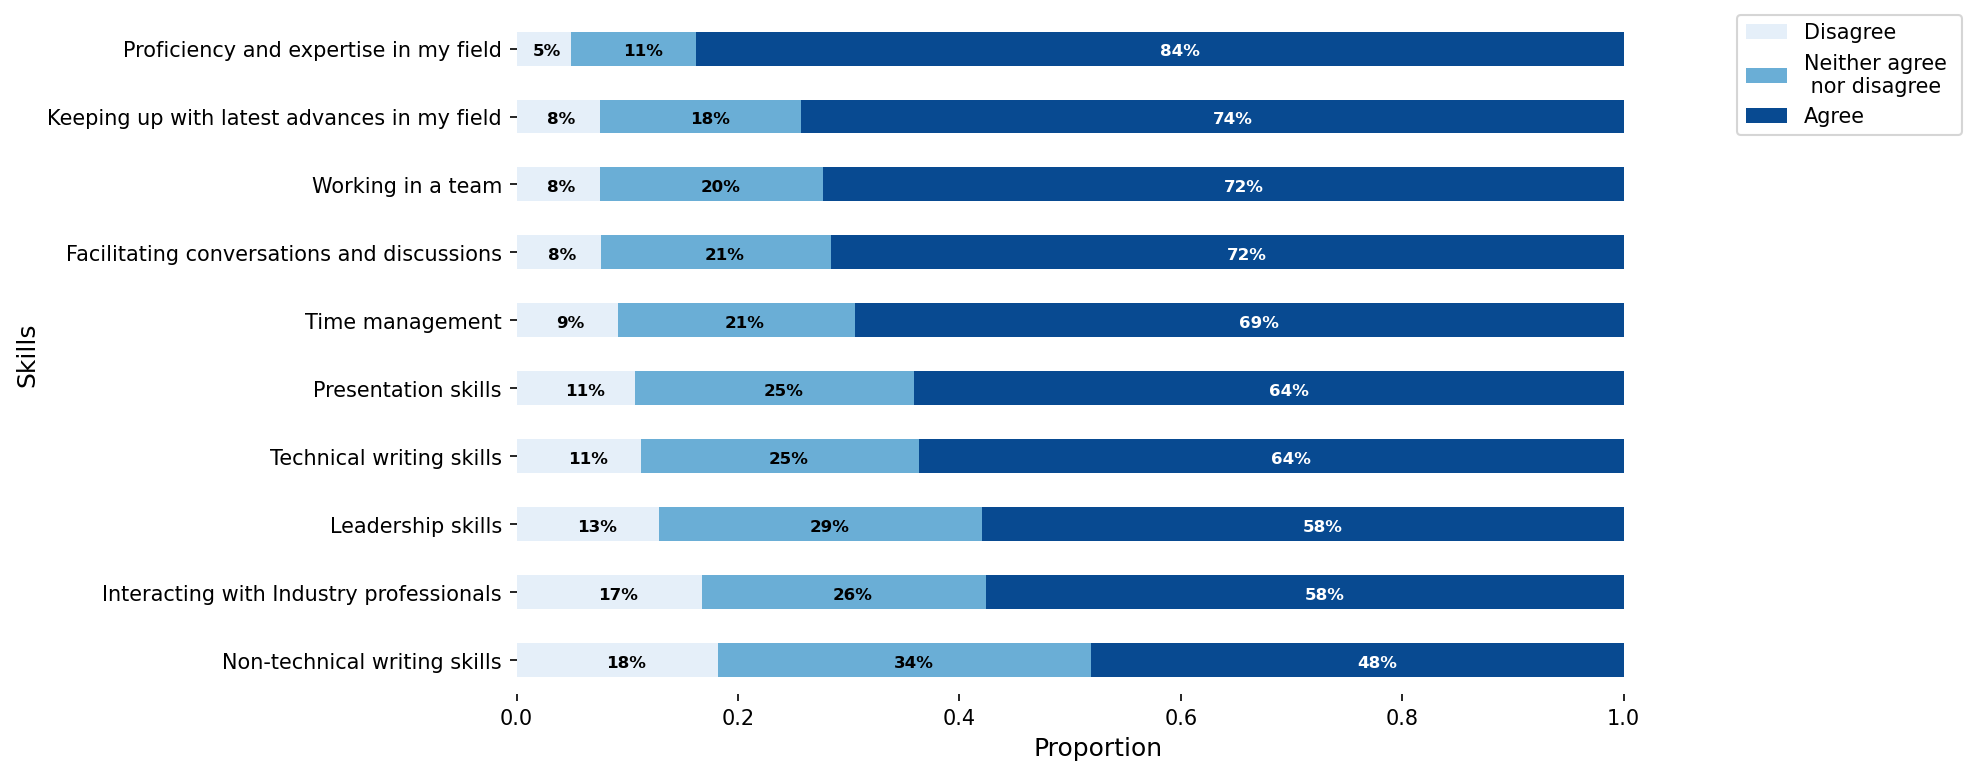

In [210]:
cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


b_prob=(skill_count[(skill_count.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(skill_count[(skill_count.iloc[2:,:].sum()).sort_values().index]).T
bbb=b_prob.T
fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind3[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Skills",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [756]:
PDL_com=query_data(Q,qq,cleaned_data,"PDL",indx=4).dropna()
PDL_com.to_csv("output/pdl_com.csv")

Please share comments regarding the PDL Program.


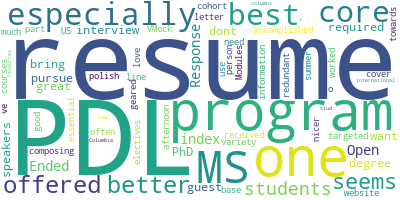

In [755]:
(PDL_com).reset_index(inplace=True)
long_string = (str((PDL_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('','')
long_string = long_string.replace('','')
long_string = long_string.replace('','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

In [671]:
(df3_2_library.mean()).sort_values().plot(kind="barh")
plt.ylabel("Resources")
plt.xlabel("importance")
plt.title("Significance of resources provided by CCE",fontsize=20)


for n,x in enumerate([*(df3_2_library.mean()).sort_values().index.values]):
        plt.text(x=0.5,
                 y=n - 0.11,
                 s=f'{df3_2_library.mean().loc[x] :0.5f}', 
                 color="white",
                 fontsize=12,
                 fontweight="bold")
        
(df3_2_library.mean()).sort_values(ascending=False)

NameError: name 'df3_2_library' is not defined

## Resources

In [211]:
resources_sat=query_data(Q,qq,cleaned_data,"satisfied",indx=6)
resources_sat.replace('Unaware of this resource',0,inplace=True)
resources_sat['degree']=degree

I am satisfied with the following resources with respect to guidance in my degree program.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1642283166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resources_sat.replace('Unaware of this resource',0,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1642283166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resources_sat['degree']=degree


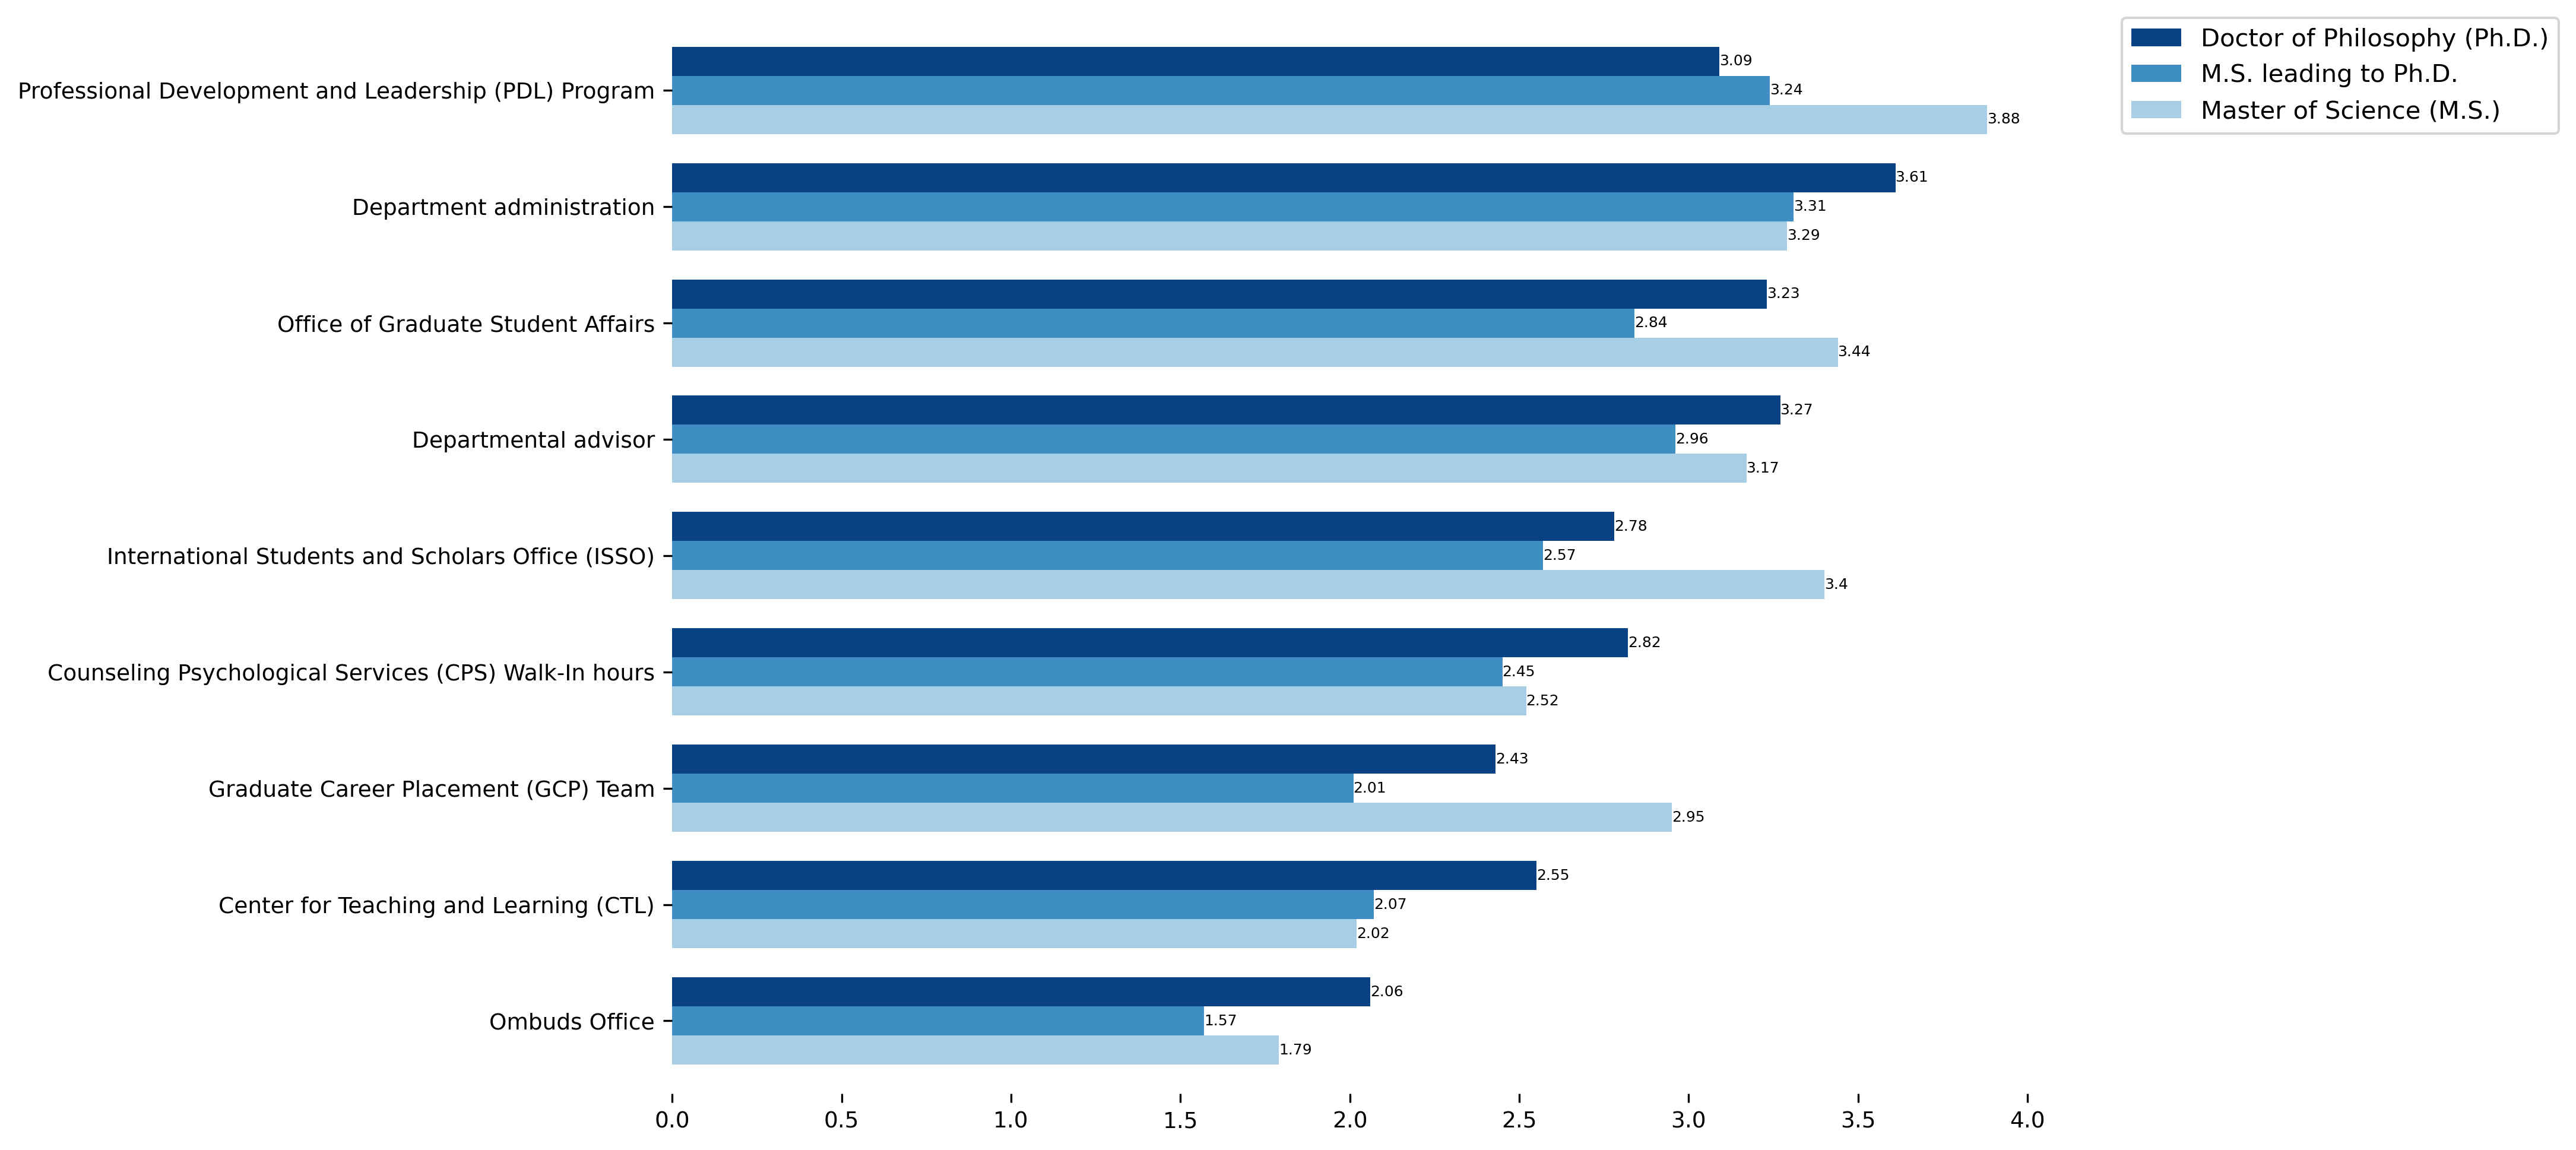

In [573]:

fig,ax=plt.subplots(figsize=(10,8),dpi=300)
aca_import['degree']=degree
df=resources_sat.groupby(['degree']).mean().round(2).drop(index='Professional Degree')
df=df[df.mean().sort_values().index[::-1]]
#indd=['Supplementary \n educational tools', 'Degree \n requirements',
 #      'Course Delivery \n Method', 'Instruction', 'Course content']
ax=df.T.plot.barh(ax=ax,colormap=cmap,width=0.75, rot=0 ,fontsize=9)
#ax.set_xticklabels( rotation=0,)
x_offset = -0.1
y_offset = 0.05
for container in ax.containers:
    ax.bar_label(container,fontsize=6)
#for p in ax.patches:
 #   b = p.get_bbox()
  #  val = "{:.2f}".format(b.x1 + b.x0)        
  #  ax.annotate(val, (( b.y1)/2+ x_offset, b.x0 +b.x1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [222]:
resources_sat=query_data(Q,qq,cleaned_data,"satisfied",indx=6)
resources_sat.replace(2,1,inplace=True)
resources_sat.replace(4,5,inplace=True)
resources_sat_count=resources_sat.apply(pd.value_counts,axis=0)
resources_sat_count.drop(index=0,inplace=True)

I am satisfied with the following resources with respect to guidance in my degree program.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2881338303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resources_sat.replace(2,1,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2881338303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resources_sat.replace(4,5,inplace=True)


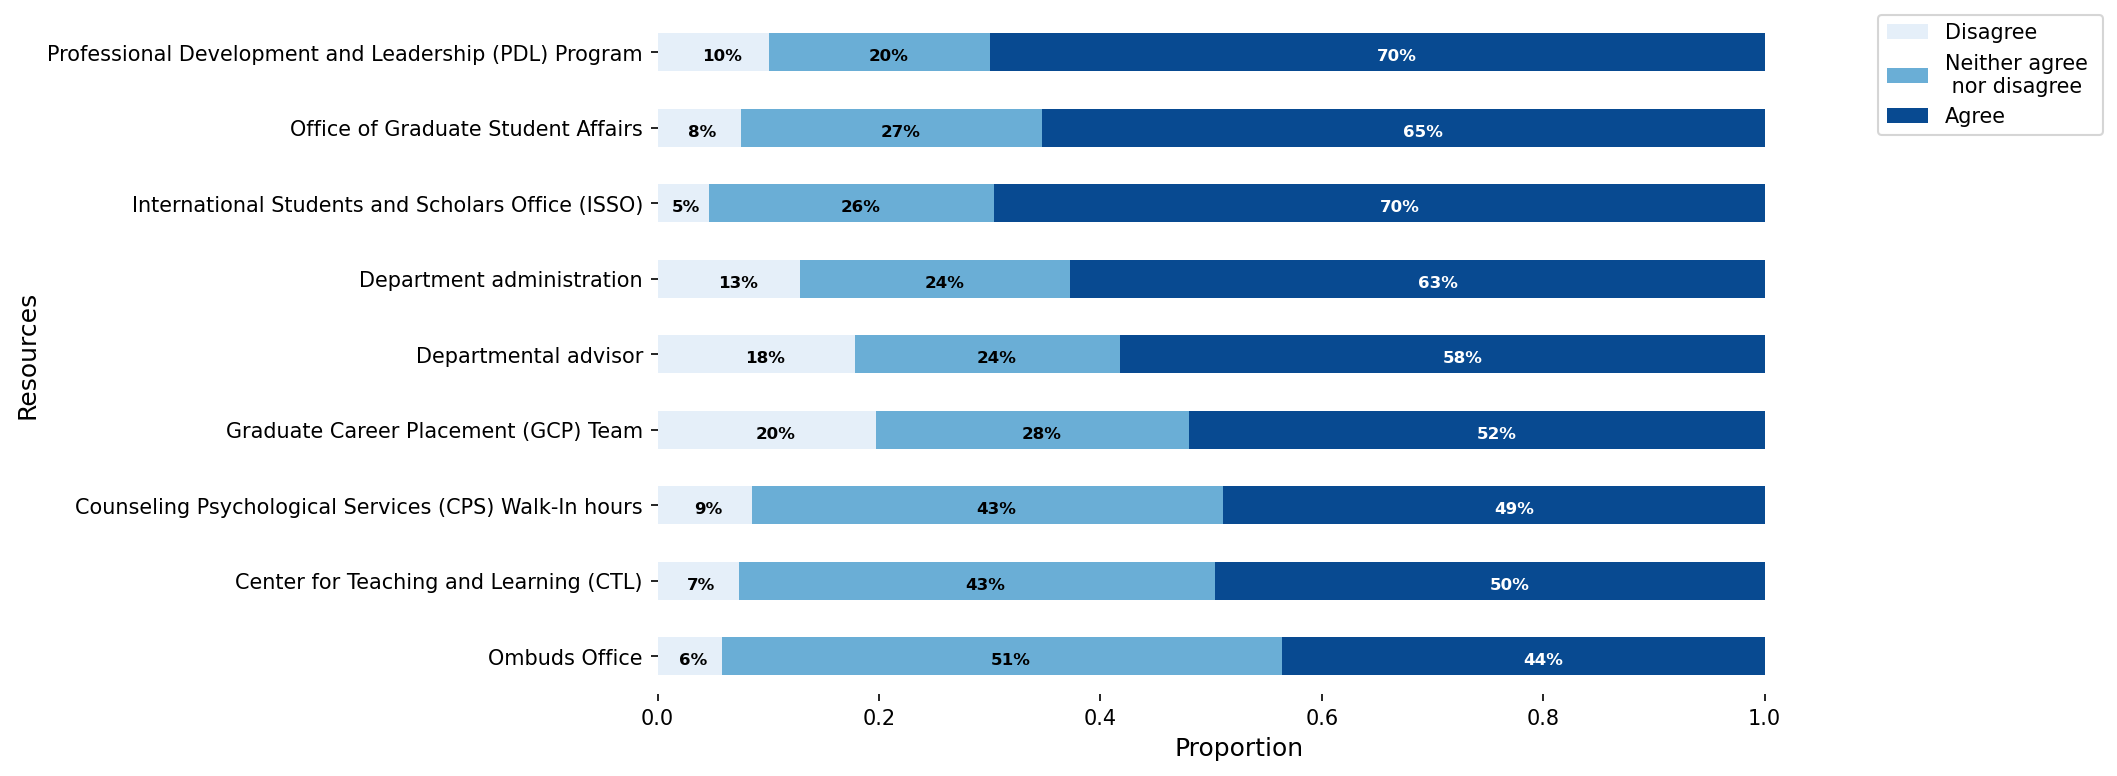

In [224]:

b_prob=(resources_sat_count[(resources_sat_count.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(resources_sat_count[(resources_sat_count.iloc[2:,:].sum()).sort_values().index]).T
bbb=b_prob.T

fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind3[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Resources",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

<BarContainer object of 9 artists>

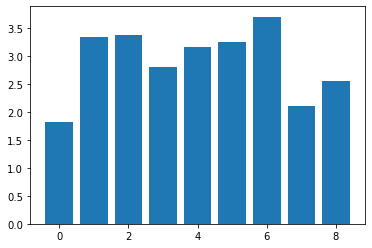

In [321]:
plt.bar(np.arange(len(resources_sat.mean(axis=0))),height=resources_sat.mean(axis=0))

## Canvas

In [235]:
canvas_sat=query_data(Q,qq,cleaned_data,"Canvas",indx=1)
canvas_sat.replace('Unaware of this Feature',0,inplace=True)
canvas_sat.replace(2,1,inplace=True)
canvas_sat.replace(4,5,inplace=True)

I find the following features of Canvas convenient.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/3438581598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canvas_sat.replace('Unaware of this Feature',0,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/3438581598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canvas_sat.replace(2,1,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/3438581598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

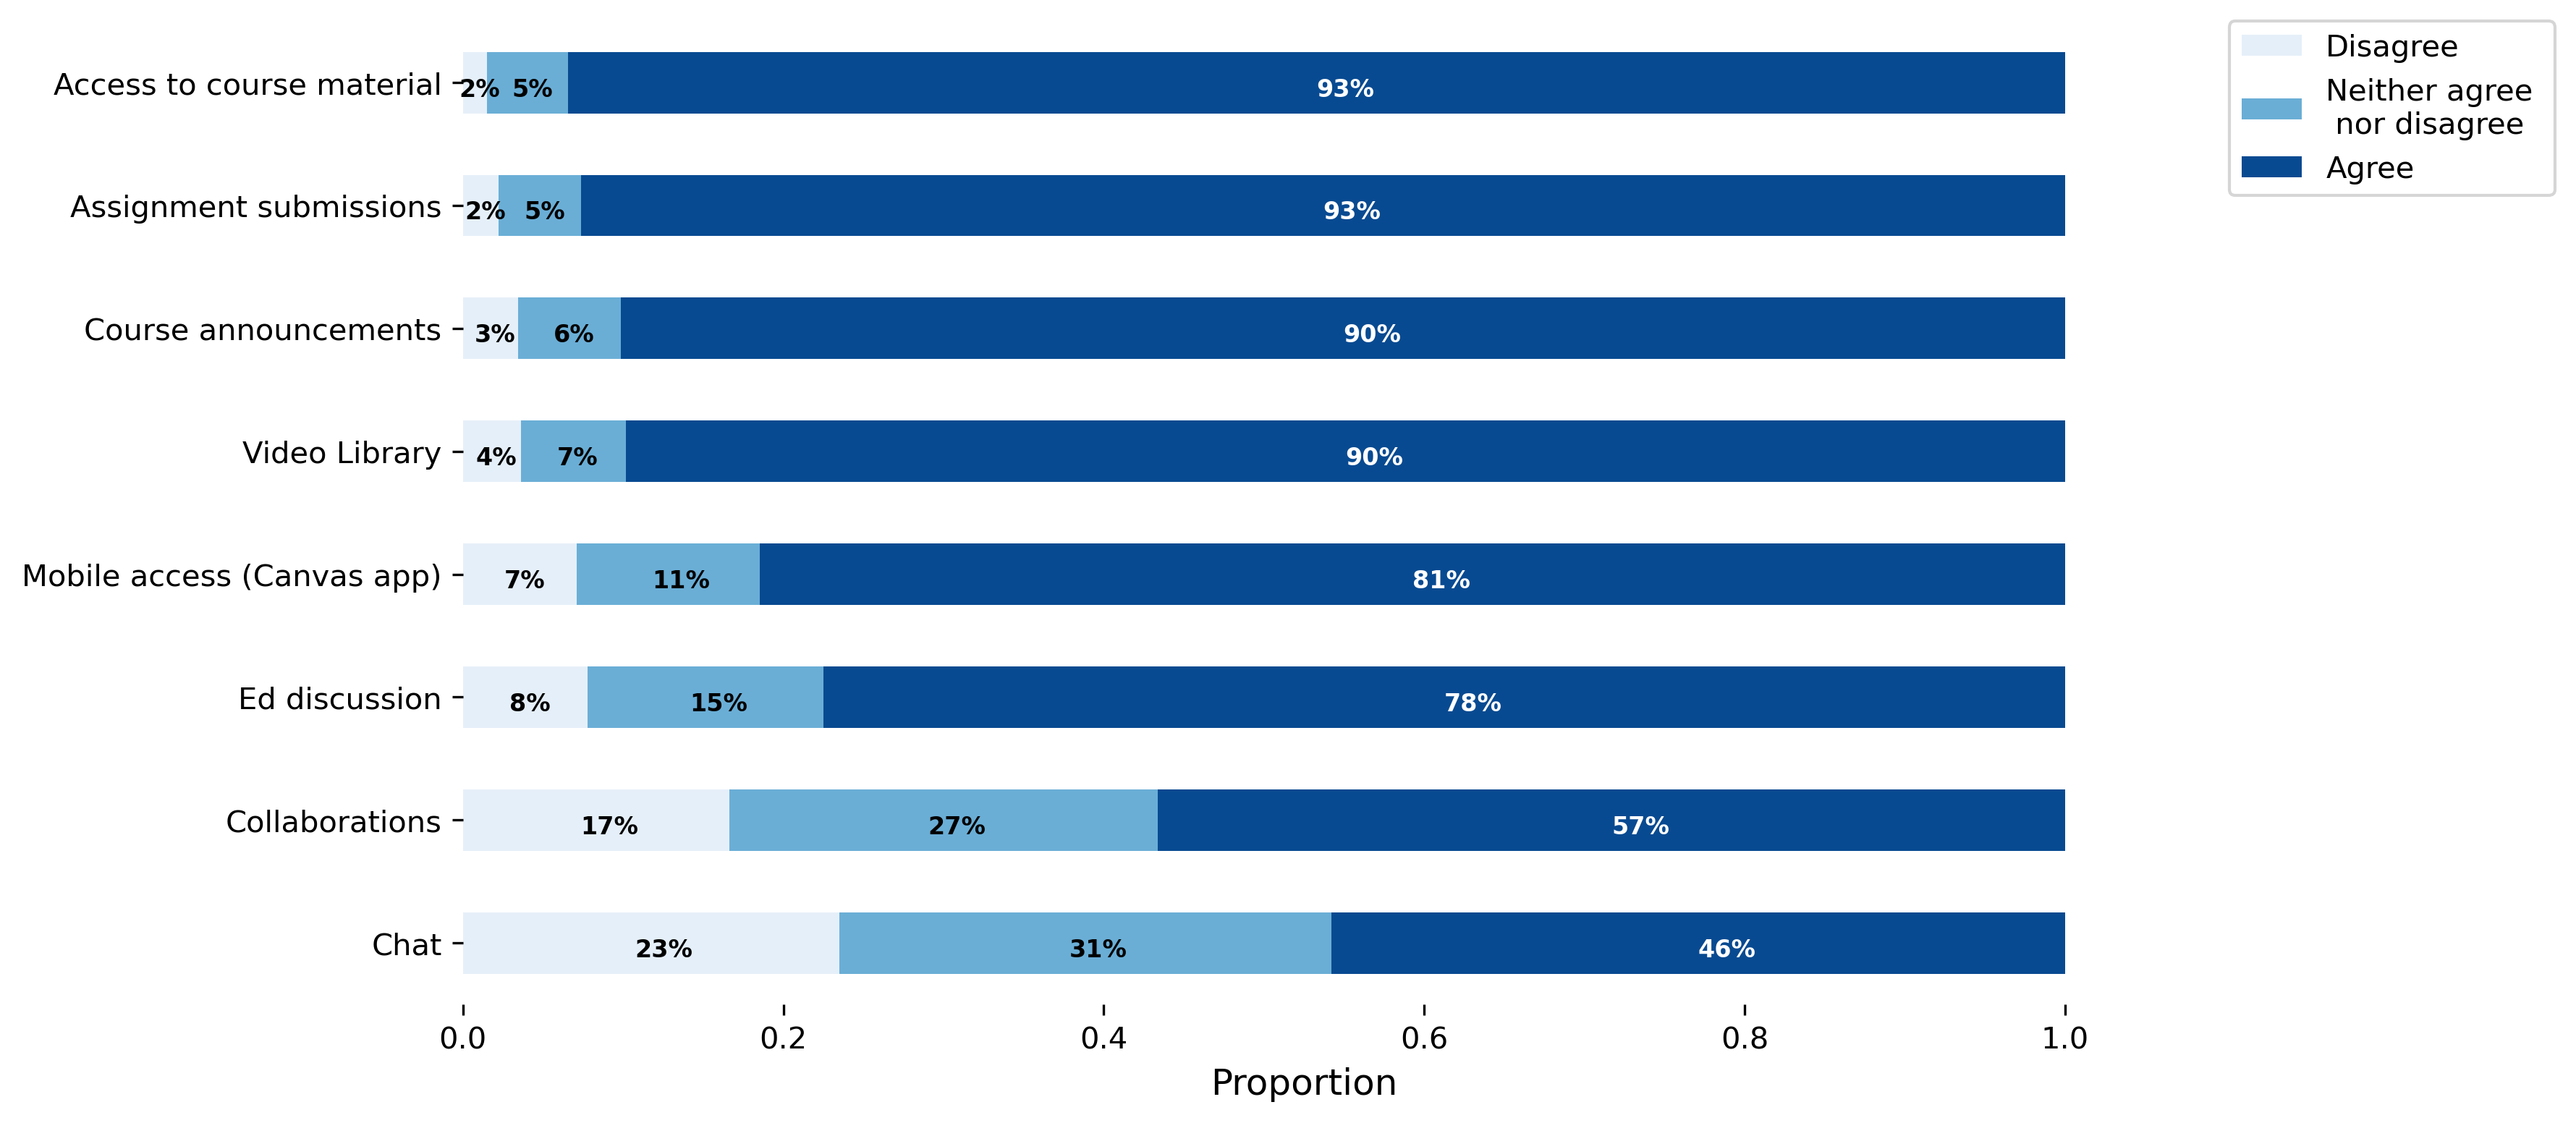

In [234]:
canvas_sat_count=canvas_sat.apply(pd.value_counts,axis=0)
canvas_sat_count.drop(index=0,inplace=True)
b_prob=(canvas_sat_count[(canvas_sat_count.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(canvas_sat_count[(canvas_sat_count.iloc[2:,:].sum()).sort_values().index]).T
bbb=b_prob.T

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind3[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
            
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [666]:
canvas_com=query_data(Q,qq,cleaned_data,"Canvas",indx=2).dropna()
(canvas_com).reset_index(inplace=True)
canvas_com
#.to_csv("output/canvas_comments.csv")

Please enter any additional comments regarding Canvas:


index  \
0        6   
1       17   
2       26   
3       43   
4       45   
..     ...   
108   1511   
109   1517   
110   1528   
111   1532   
112   1549   

                                                                                                         Open-Ended Response  
0                                                     Email notifications are usually a bit late but overall it's still good  
1                                                                       please provide a way to contact people from my class  
2    2 out of 8 of my classes used any collaboration with students, TAs, and Professors in forum format (e.g., ask a ques...  
3    On my phone, I always get the same annoucement 2 times on canvas and one time from email. And when prof adding annot...  
4                                                                                                       The inbox is great.   
..                                                                                                                       ...  
108                                                            Canvas keeps sending repeated notifications which is annoying  
109                                                                                                      i do not have any.   
110  Canvas, while on hand is really intuitive, has its way of portraying legacy technology based applications which migh...  
111  I don't use Chat at all.  I don't like Ed as much as I liked Piazza.  The assignment and video library are good feat...  
112                                                                                 its not great but really doesn't matter   

[113 rows x 2 columns]

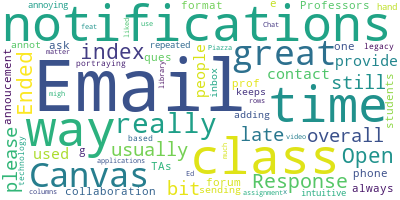

In [648]:
from wordcloud import WordCloud
long_string = (str((canvas_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('canvas','')
long_string = long_string.replace('good','')
#long_string = long_string.replace('one','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

## SSOL

In [236]:
ssol_sat=query_data(Q,qq,cleaned_data,"SSOL",indx=1)
ssol_sat.replace('Unaware of this Feature',0,inplace=True)
ssol_sat.replace(2,1,inplace=True)
ssol_sat.replace(4,5,inplace=True)

I find the following features of SSOL convenient.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/908525744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssol_sat.replace('Unaware of this Feature',0,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/908525744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssol_sat.replace(2,1,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/908525744.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

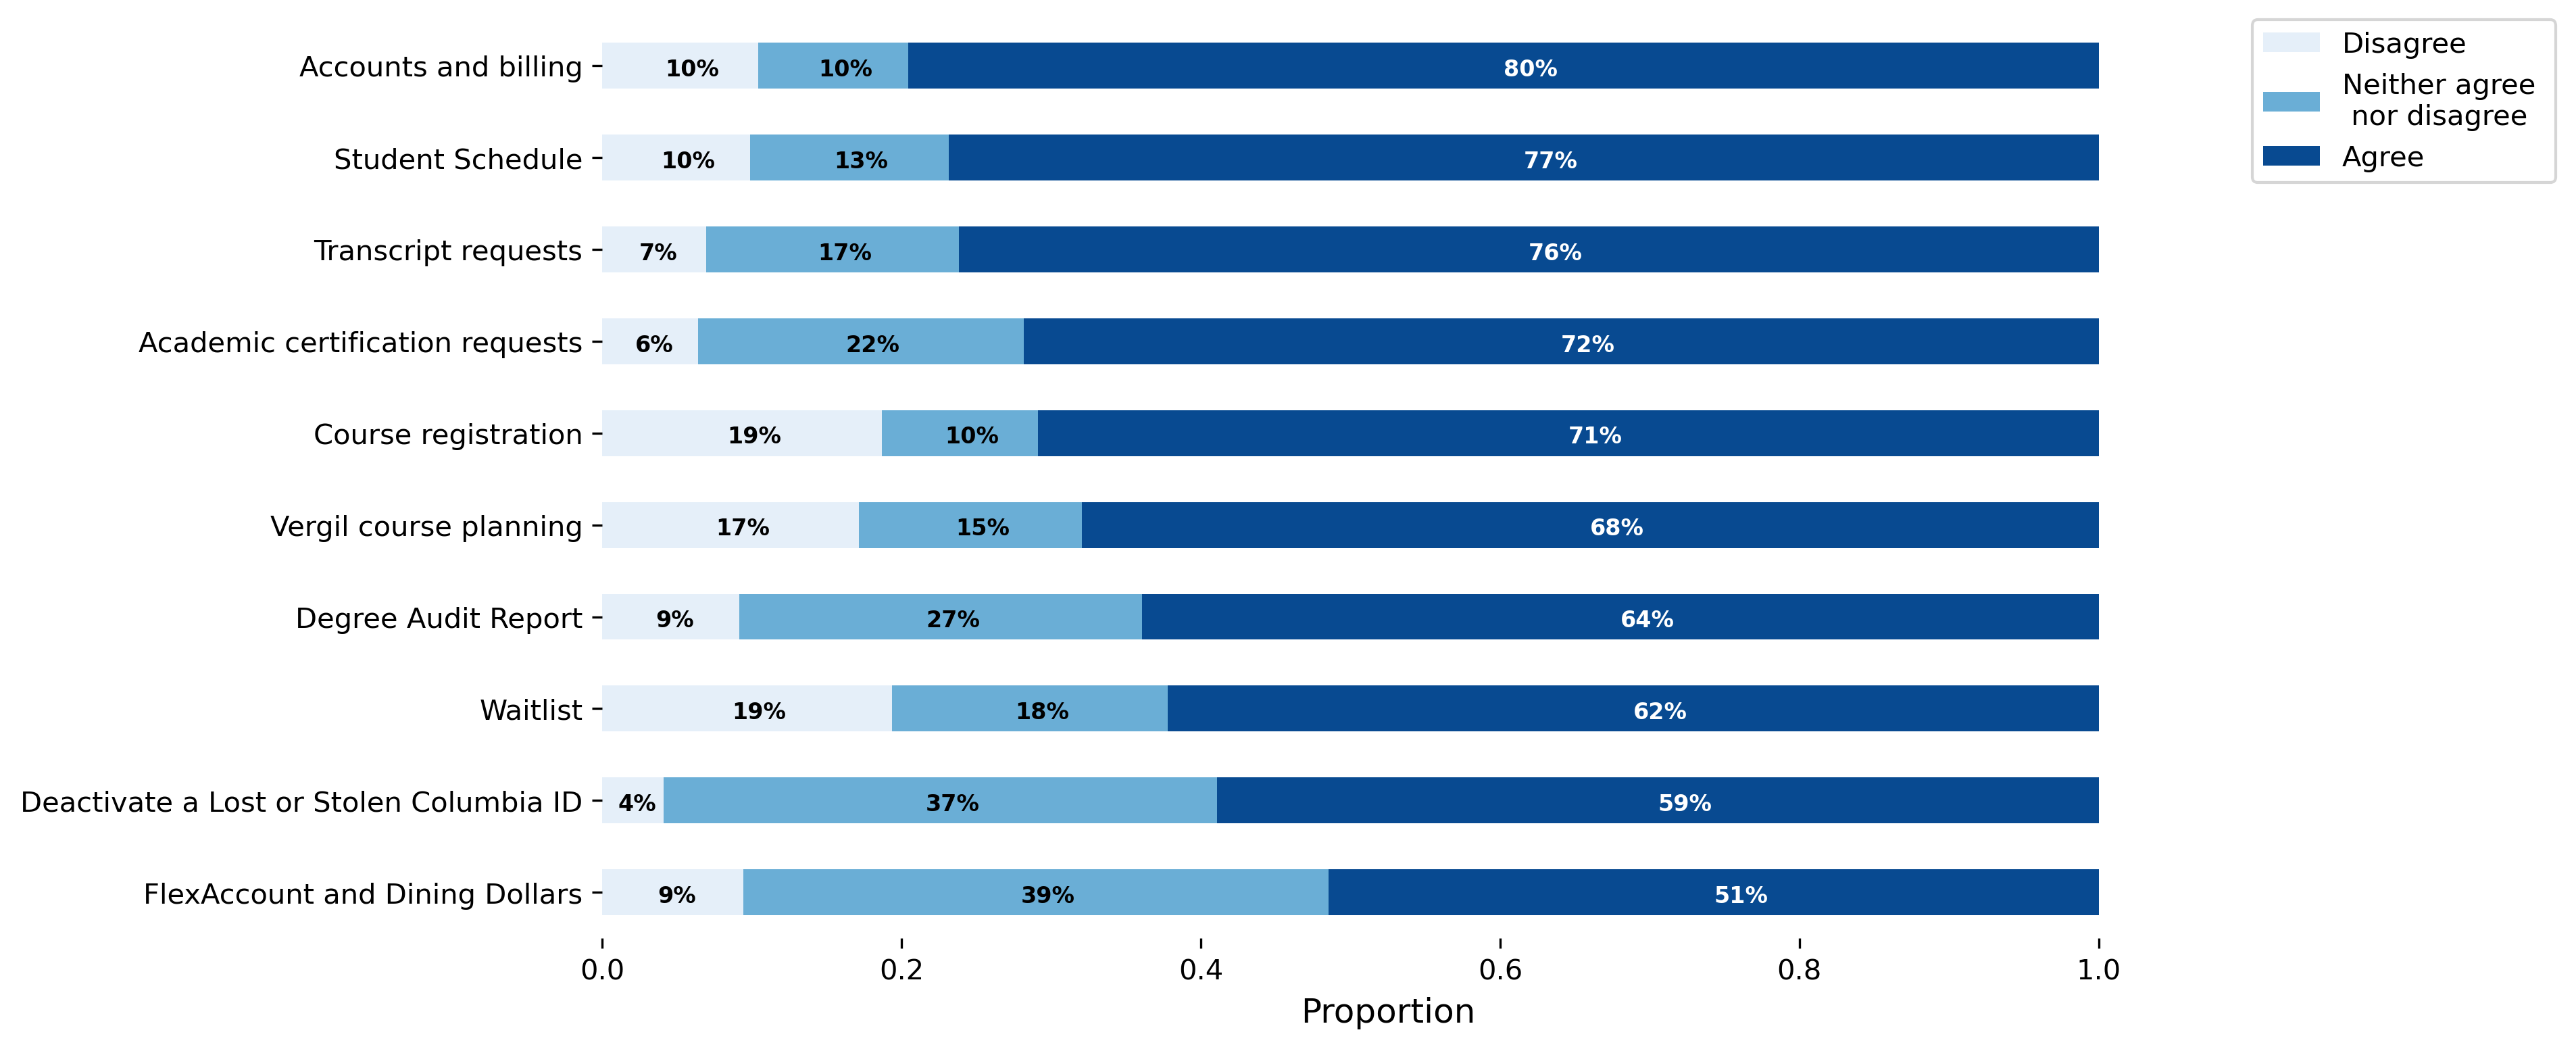

In [239]:
ssol_sat_count=ssol_sat.apply(pd.value_counts,axis=0)
ssol_sat_count.drop(index=0,inplace=True)
b_prob=(ssol_sat_count[(ssol_sat_count.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
b_prob=b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]
aaa=(ssol_sat_count[(b_prob.iloc[2:,:].sum()).sort_values().index]).T
bbb=b_prob.T

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind3[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
            
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [654]:
ssol_com=query_data(Q,qq,cleaned_data,"SSOL",indx=2).dropna()
(ssol_com).reset_index(inplace=True)
ssol_com
#.to_csv("output/ssol_comments.csv")

Please enter any additional feedback you might have regarding SSOL:


index  \
0        6   
1       17   
2       26   
3       39   
4       43   
..     ...   
160   1510   
161   1517   
162   1533   
163   1540   
164   1549   

                                                                                                       Open-Ended Response.1  
0                                                                  It would be nice to not have strict registration windows.  
1    why are there two websites? remove virgil and just make SSOL the only website tat has to do with finding classes for...  
2    Neither agree nor disagree is I have not used it.  Course registration the first time around was confusing.  Maybe I...  
3                                                            Cannot submit the graduation application form directly on SSOL.  
4    The time to get paper edition transcript takes too long, and for international students, if we will go back to our h...  
..                                                                                                                       ...  
160  Columbia really needs to modernize Vergil/Course Catalog/SSOL. Current UI is terrible. Also, we need to have one pla...  
161                                                 SSOL must be redesigned. A total disaster of a website. Smells like 90s.  
162                                                   Really needs an update: no reason for there to be registration periods  
163                                                                  Canvas' schedule more useful and accessible than SSOL's  
164  it's a bargain bin solution, and it shows. (doesn't the universty have money for things other than the lawn?)   the ...  

[165 rows x 2 columns]

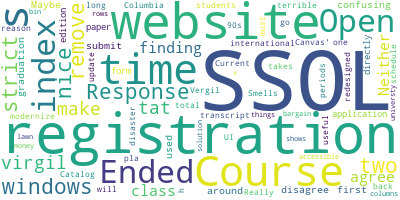

In [664]:
long_string = (str((ssol_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('','')
long_string = long_string.replace('really','')
long_string = long_string.replace('need','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

In [655]:

import sklearn.feature_extraction.text as sk_text
Tfidf_vectorizer = sk_text.TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
stop_words= 'english',ngram_range=(1,1), min_df = .05 , max_df = .85)

matrix = Tfidf_vectorizer.fit_transform(ssol_com['Open-Ended Response.1'])


In [660]:
from sklearn.decomposition import LatentDirichletAllocation


lda=LatentDirichletAllocation(n_components=20,n_jobs=-1,
                             random_state=123)


X_lda=lda.fit_transform(matrix)
  

In [661]:
vocab=Tfidf_vectorizer.get_feature_names()

vocab=np.array(vocab)

for topic_idx in range(20):
    a=vocab[np.argsort(lda.components_[topic_idx])[::-1][:5]]
    b=' '.join(a)
    print(f'Topic #{topic_idx:2d} : {b}')
 

Topic # 0 : vergil course use registration know
Topic # 1 : registration students day time course
Topic # 2 : transcript know students time doesn
Topic # 3 : waitlist know like course students
Topic # 4 : registration students course like ssol
Topic # 5 : classes ssol vergil course like
Topic # 6 : time registration students course classes
Topic # 7 : doesn waitlist ssol registration know
Topic # 8 : day registration time students like
Topic # 9 : registration students course like ssol
Topic #10 : need use registration course billing
Topic #11 : user interface like use ssol
Topic #12 : registration students course like ssol
Topic #13 : ssol like use waitlist course
Topic #14 : day like use waitlist course
Topic #15 : better use waitlist registration vergil
Topic #16 : registration students course like ssol
Topic #17 : courses course waitlist day registration
Topic #18 : billing students know day registration
Topic #19 : course registration like students ssol


## Library

In [ ]:
How many times per week do you frequent the following libraries?

In [245]:
lib_fre=query_data(Q,qq,cleaned_data,"libraries",indx=1)
lib_fre.replace("2-Jan","1-2",inplace=True)
lib_fre.replace("3-Feb",'2-3',inplace=True)
lib_fre.replace("4-Mar","3-4",inplace=True)

How many times per week do you frequent the following libraries?


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1646517544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lib_fre.replace("2-Jan","1-2",inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1646517544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lib_fre.replace("3-Feb",'2-3',inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1646517544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

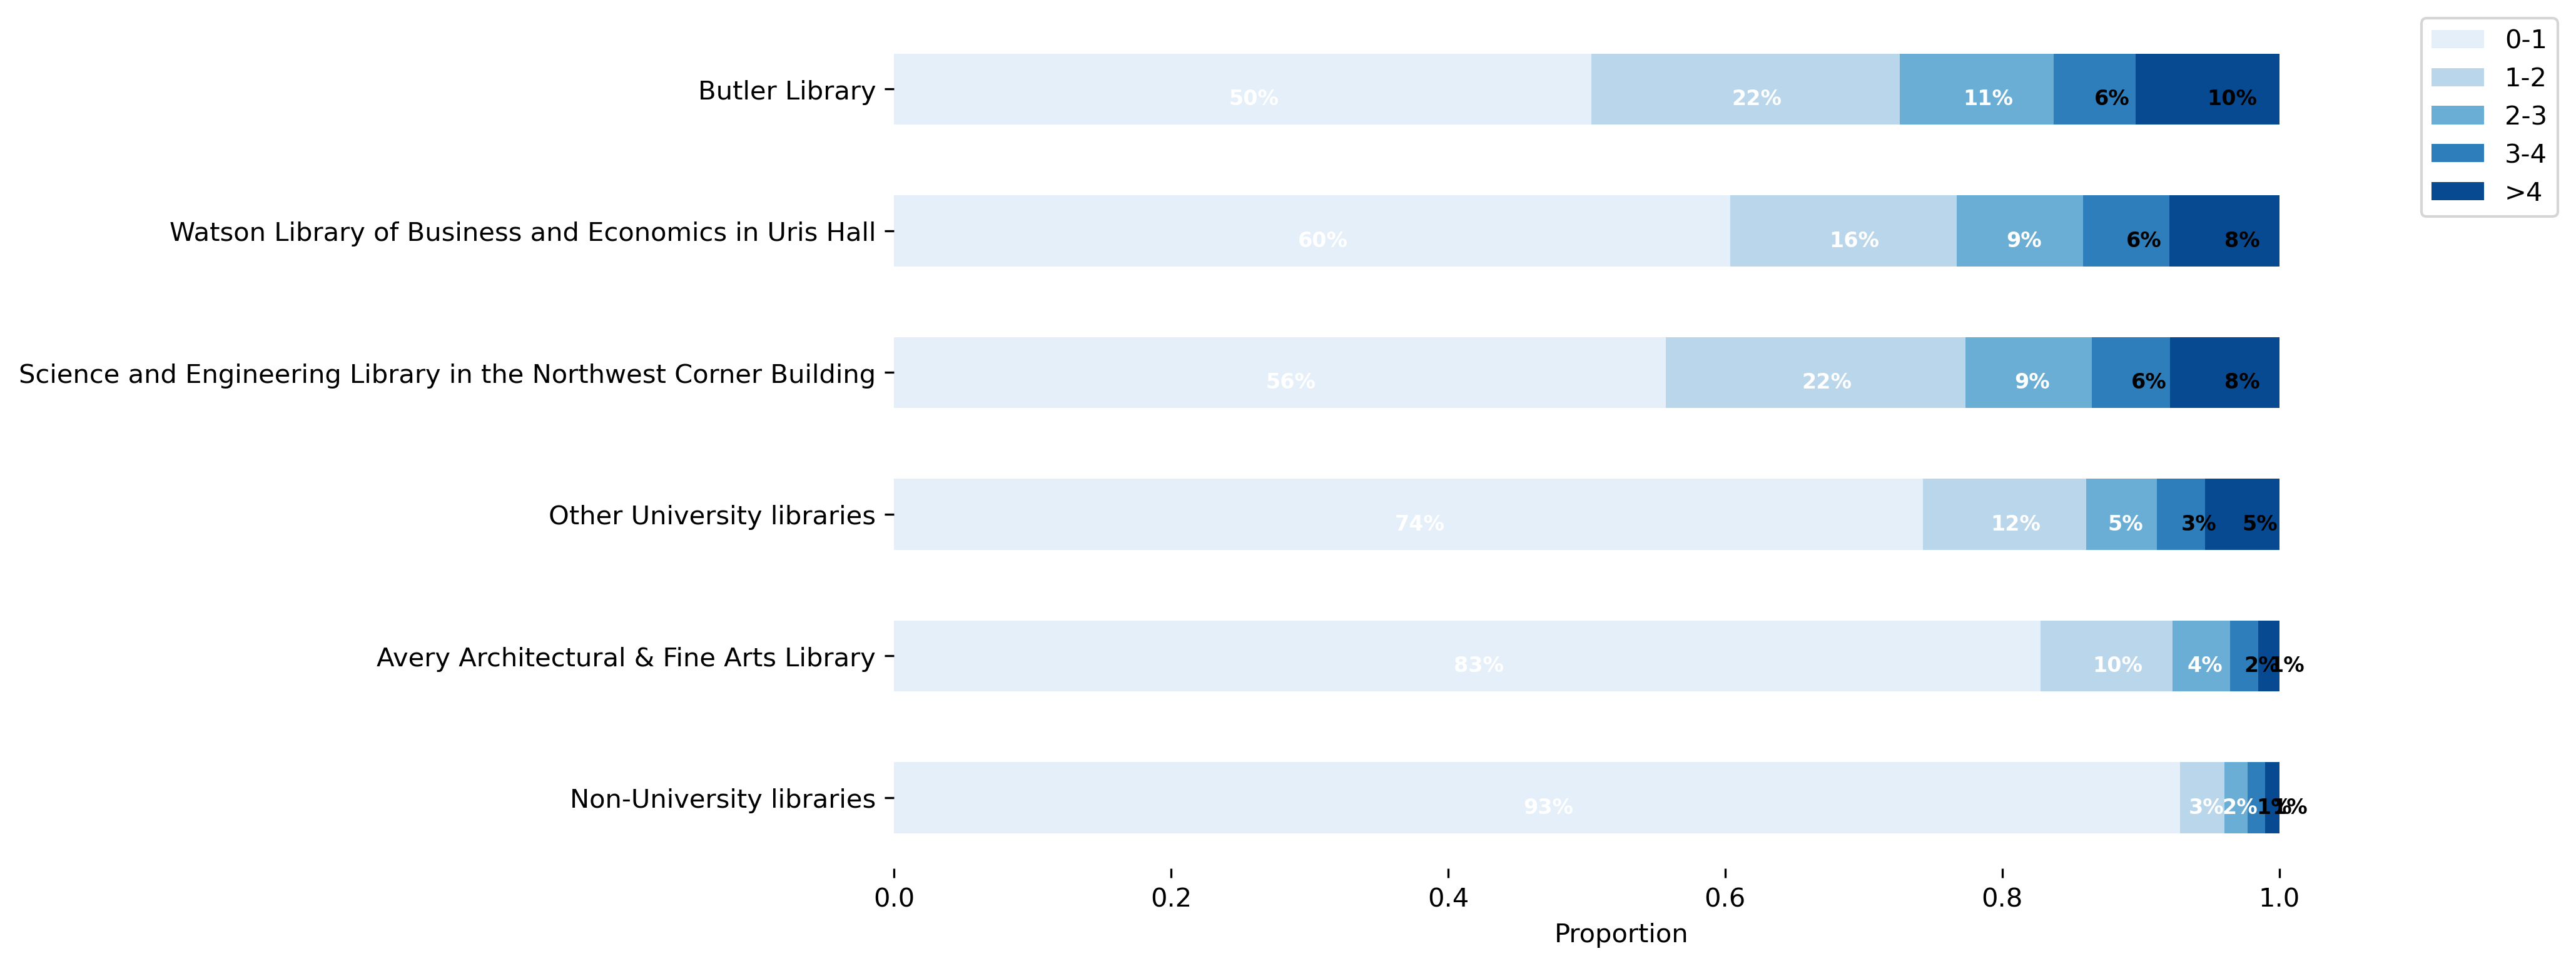

In [246]:
lib_fre_count=lib_fre.apply(pd.value_counts,axis=0)
b_prob=(lib_fre_count[(lib_fre_count.iloc[3:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(lib_fre_count[(lib_fre_count.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob.T


fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}',
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

Please enter any suggestions or additional comments regarding library resources for engineers at Columbia below:


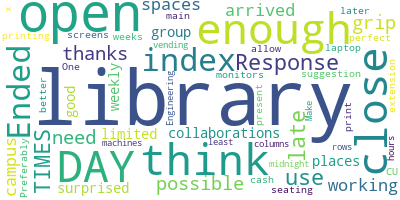

In [884]:
lib_com=query_data(Q,qq,cleaned_data,"comments regarding library resources for engineers at Columbia below:",indx=1).dropna()
lib_com.to_csv("output/lib_com.csv")
(lib_com).reset_index(inplace=True)
long_string = (str((lib_com)))
long_string = long_string.replace('libraries','library')
long_string = long_string.replace('please','')
long_string = long_string.replace('make','')
long_string = long_string.replace('','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

### gender-neutral bathrooms

In [917]:
gnb=query_data(Q,qq,cleaned_data,"gender-neutral bathrooms",indx=1)
indgnb=['I was unaware of \n the gender-neutral \n bathrooms in Mudd','No','Yes']

Are you satisfied with the gender-neutral bathrooms in Mudd and Engineering Terrace?


In [909]:
gnb_gender['Response.22']

0                                                          No
2       I was unaware of the gender-neutral bathrooms in Mudd
5       I was unaware of the gender-neutral bathrooms in Mudd
6                                                          No
7       I was unaware of the gender-neutral bathrooms in Mudd
                                ...                          
1585                                                      Yes
1586                                                      Yes
1587                                                      Yes
1588                                                      Yes
1590                                                      Yes
Name: Response.22, Length: 1271, dtype: object

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


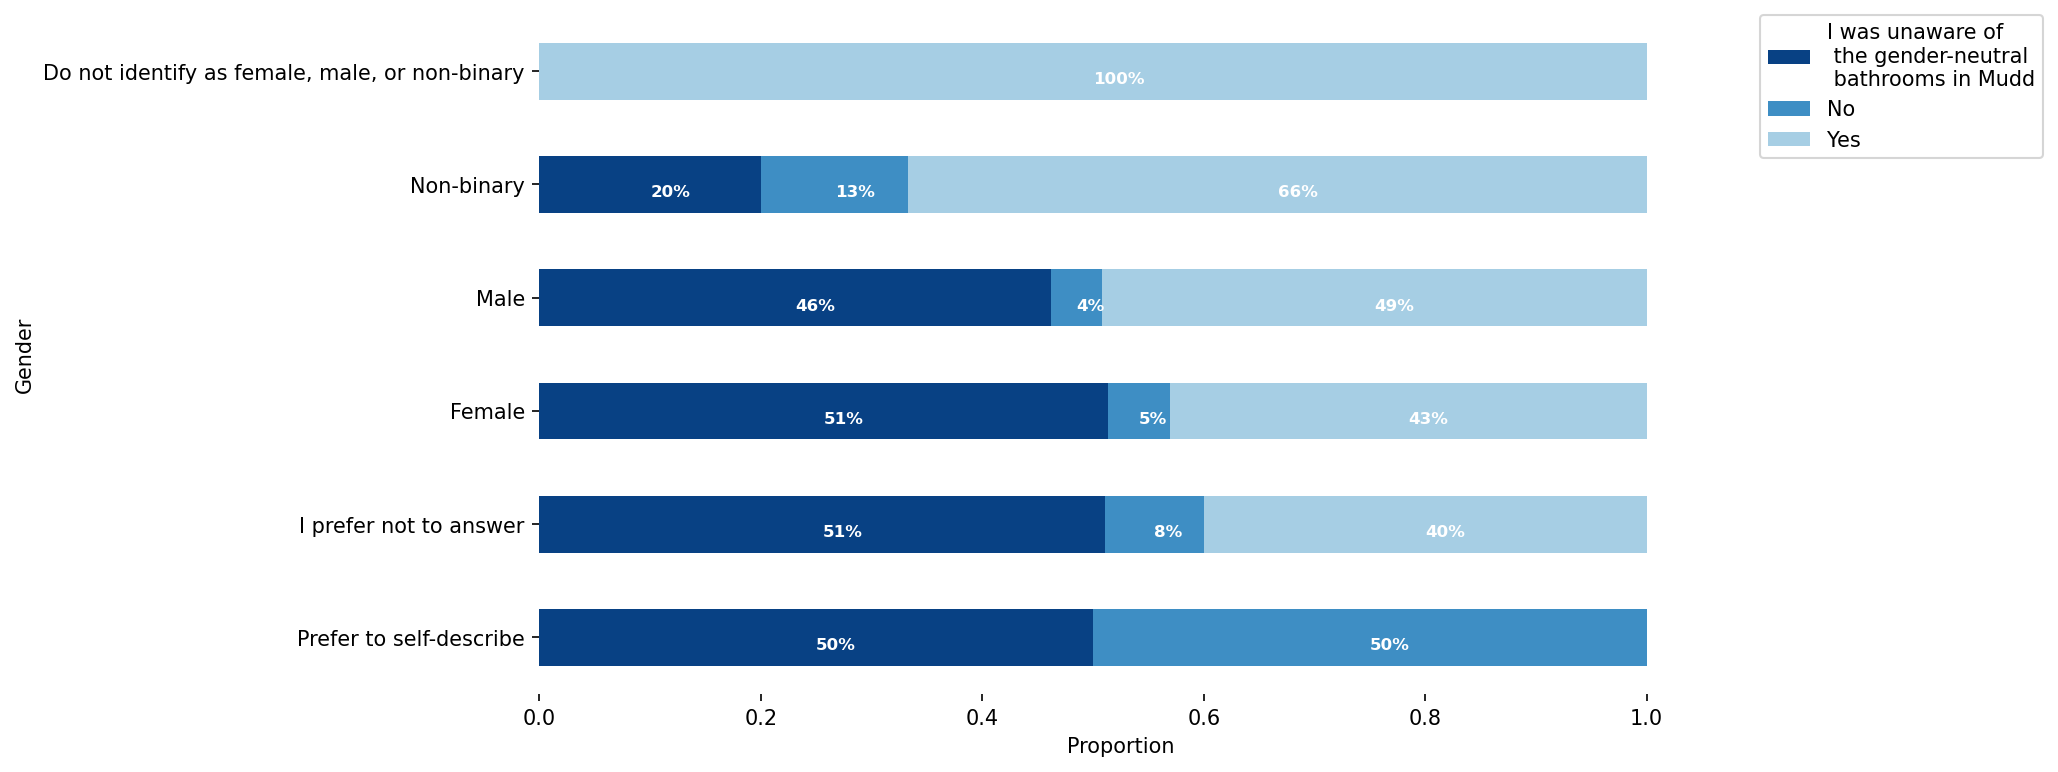

In [918]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


gnb_gender=gnb.copy()
gnb_gender=gnb_gender.join(gender)

gender_c=['Female','Male','Non-binary','Do not identify as female, male, or non-binary','I prefer not to answer','Prefer to self-describe']
b=pd.DataFrame(columns=gender_c) 
for i in gender_c:
    data_used=gnb_gender.loc[gnb_gender[i].isna()!=True,'Response.22']
    b[i]=(pd.DataFrame(data_used.value_counts()).fillna(0)/pd.DataFrame(data_used).count(axis=0)*100)
    #print(pd.DataFrame(data_used).count(axis=0))  
 #b.append(a)

b=b[['Prefer to self-describe','I prefer not to answer','Female','Male','Non-binary','Do not identify as female, male, or non-binary']]
b_prob=b.apply(lambda x: x / x.sum(), axis=0)
aaa=b.sort_index().T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indgnb,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Gender")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Gender",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}%', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}%', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## SEL

In [249]:
sel=query_data(Q,qq,cleaned_data,"Engineering Library",indx=1)
sel.replace(2,1,inplace=True)
sel.replace(4,5,inplace=True)
sel_count=sel.apply(pd.value_counts,axis=0)
sel_count


The following resources at Science and Engineering Library are useful to me:


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/208774930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel.replace(2,1,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/208774930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel.replace(4,5,inplace=True)


Individual study and/or work space  Group study and/or work space  \
1                                  96                            130   
3                                 332                            389   
5                                 843                            752   

   Reference materials  Computer terminal  Printing and scanning facilities  \
1                  151                168                               102   
3                  622                532                               368   
5                  498                571                               801   

   Hours of operation  
1                 127  
3                 419  
5                 725

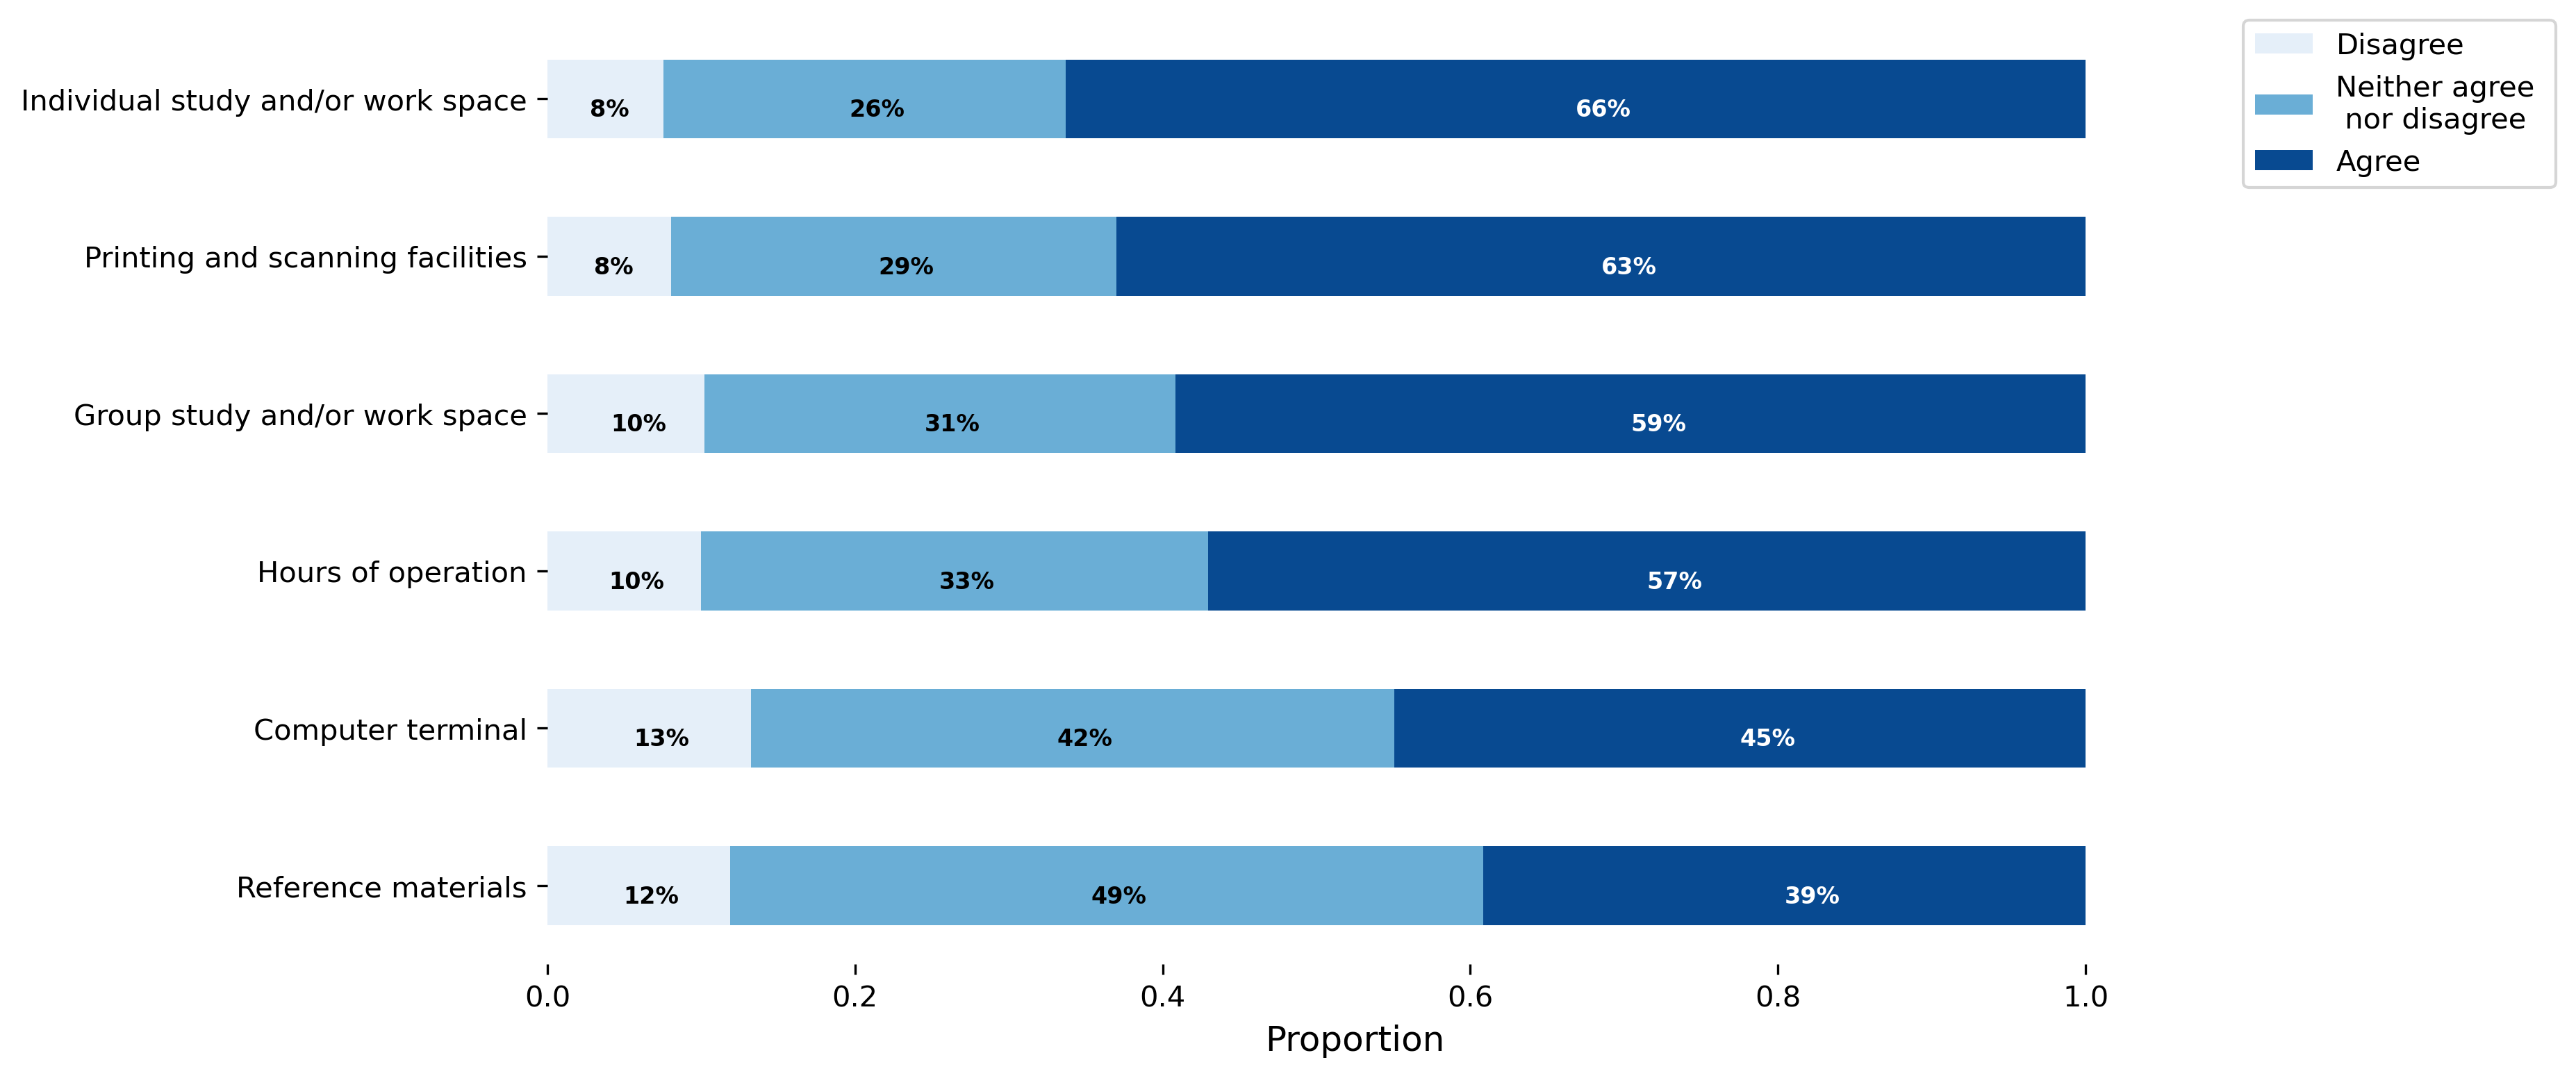

In [250]:
sel_count=sel.apply(pd.value_counts,axis=0)
b_prob=(sel_count[(sel_count.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
b_prob=b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]
aaa=(sel_count[(b_prob.iloc[2:,:].sum()).sort_values().index]).T
bbb=b_prob.T

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind3[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
            
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## Facility

In [749]:
inddf=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Not Applicable']

University Gym  \
0             190   
1             169   
2             177   
3             229   
4             293   
5             213   

   Availability of transportation to the CUIMC campus on the weekends  \
0                                                                 396   
1                                                                  49   
2                                                                  64   
3                                                                 311   
4                                                                 251   
5                                                                 200   

   Columbia Makerspace  Computer Lab at the Engineering Terrace 251/252  \
0                  413                                              404   
1                   18                                               16   
2                   21                                               29   
3                  307                                              326   
4                  301                                              292   
5                  211                                              204   

   Availability of reservable student group space  \
0                                             165   
1                                              80   
2                                             160   
3                                             263   
4                                             379   
5                                             224   

   Quality and maintenance of equipment in labs  \
0                                           291   
1                                            18   
2                                            53   
3                                           260   
4                                           397   
5                                           252   

   Availability of group study space  \
0                                105   
1                                 77   
2                                179   
3                                242   
4                                420   
5                                248   

   Availability of advanced computing resources  \
0                                           251   
1                                            24   
2                                            70   
3                                           309   
4                                           370   
5                                           247   

   Availability of engineering specific software in libraries/computer labs  \
0                                                                       262   
1                                                                        19   
2                                                                        56   
3                                                                       313   
4                                                                       376   
5                                                                       245   

   Availability of engineering specific software that can be installed on your personal computer  \
0                                                                                            154   
1                                                                                             59   
2                                                                                            123   
3                                                                                            267   
4                                                                                            399   
5                                                                                            269   

   Department lounge  Carleton Commons  Elevators in Mudd building  \
0                157               212                          49   
1                 82                16               

In [251]:
fac=query_data(Q,qq,cleaned_data,"I am satisfied with the following.",indx=3)
fac.replace("Not Applicable",0,inplace=True)
fac.replace(2,1,inplace=True)
fac.replace(4,5,inplace=True)
fac_count=fac.apply(pd.value_counts,axis=0)
fac0=fac_count[(fac_count.iloc[3:,:].sum()).sort_values().index]
fac1=fac0.iloc[:,:10]
fac1.drop(index=0,inplace=True)

I am satisfied with the following.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2958054960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac.replace("Not Applicable",0,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2958054960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac.replace(2,1,inplace=True)
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2958054960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [266]:
#fac1_count=fac1.apply(pd.value_counts,axis=0)
fac1_prob=(fac1).apply(lambda x: x / x.sum(), axis=0)
proind=(fac1_prob.iloc[2:,:].sum()).sort_values().index
aaa=(fac1[proind]).T
bbb=fac1_prob[proind].T
#bbb

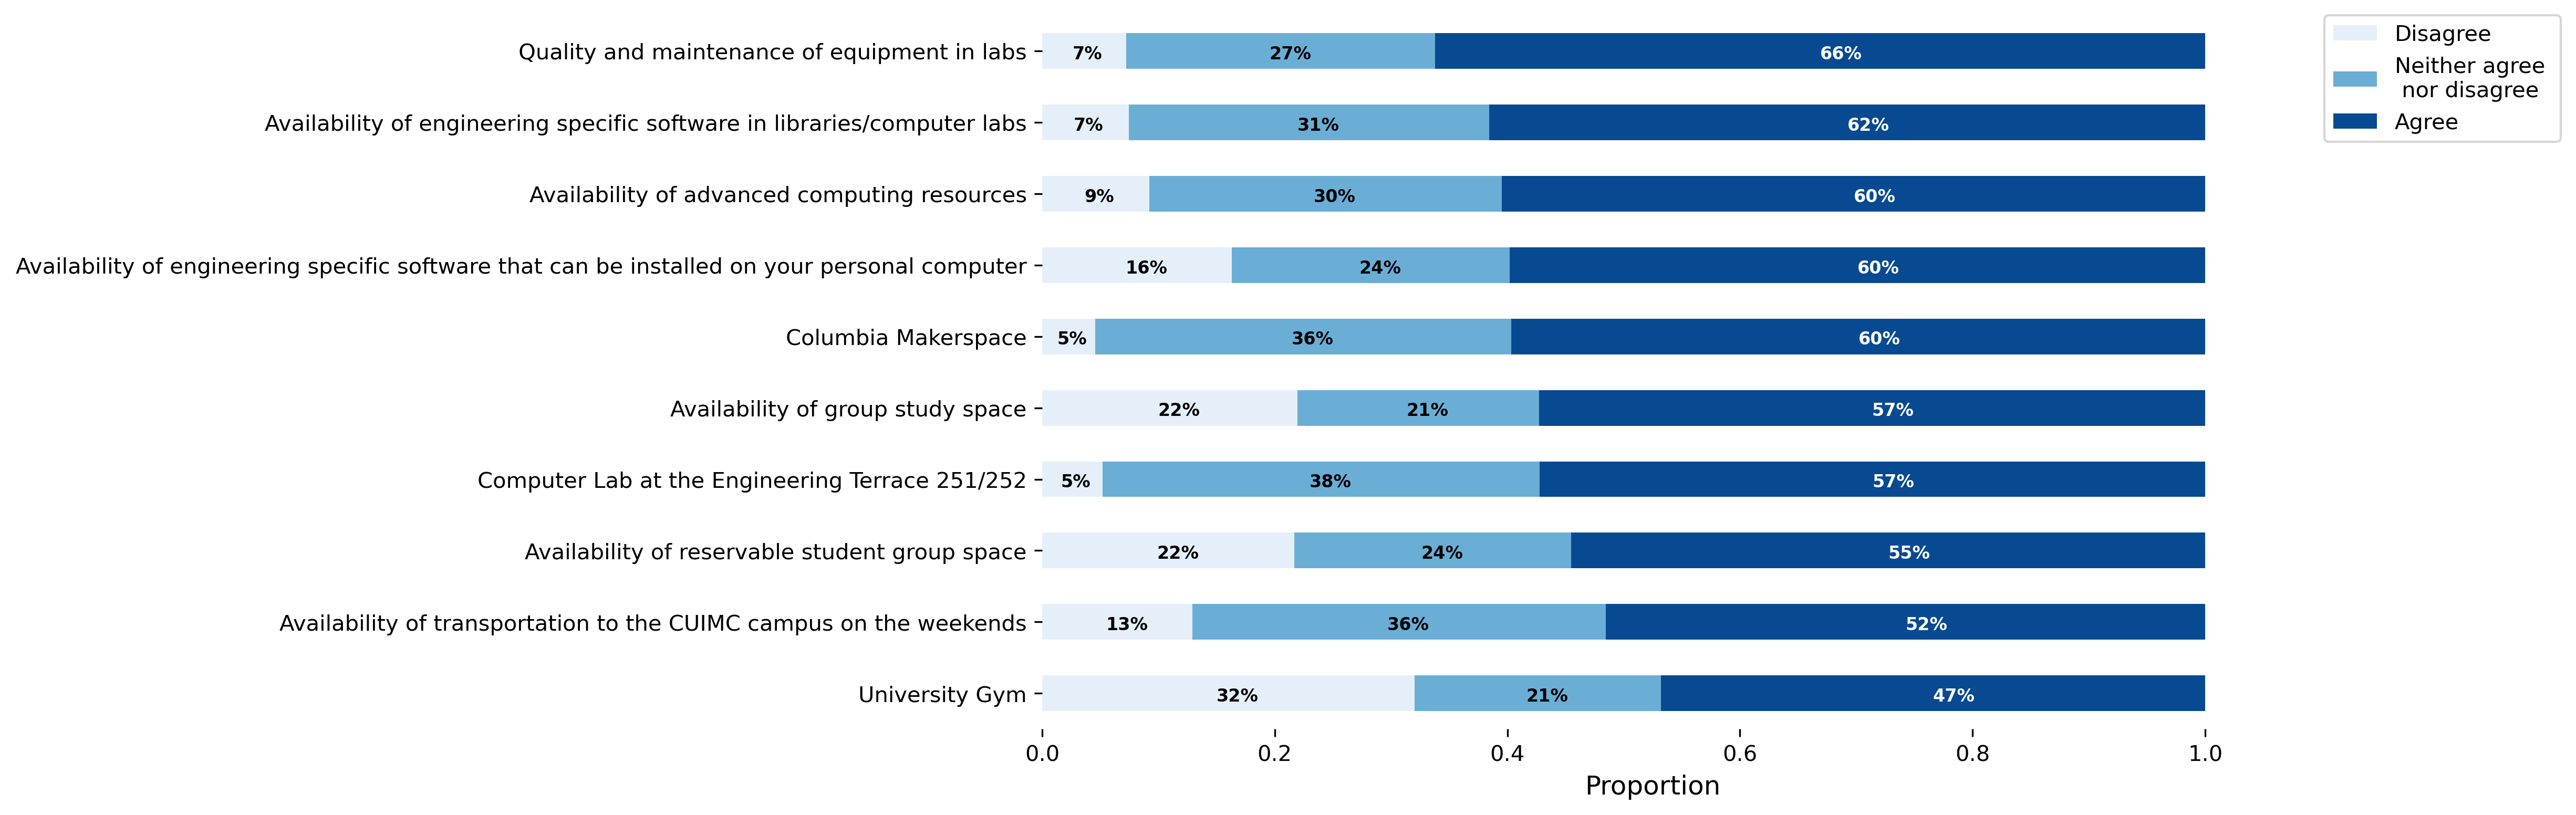

In [264]:
fig,ax=plt.subplots(figsize=(8,6),dpi=300)
bbb.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind3[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
            
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [275]:
fac2

Department lounge  Carleton Commons  \
0                157               212   
1                179                97   
3                252               273   
5                683               689   

   Quality of technical support provided by CUIT  \
0                                            207   
1                                             77   
3                                            274   
5                                            713   

   Speed of wired internet in Mudd and CEPSR  Elevators in Mudd building  \
0                                        240                          49   
1                                         32                         243   
3                                        220                         199   
5                                        779                         780   

   Cleanliness of laboratory and office space  \
0                                         196   
1                                          64   
3                                         216   
5                                         795   

   Accessibility of Mudd on the weekends  \
0                                    139   
1                                    106   
3                                    228   
5                                    798   

   Speed of wireless internet in Mudd and CEPSR  \
0                                            69   
1                                            61   
3                                           185   
5                                           956   

   Coverage of wireless internet in Mudd and CEPSR  \
0                                               68   
1                                               48   
3                                              188   
5                                              967   

   Overall cleanliness of classrooms in the Mudd building  
0                                                      45  
1                                                      68  
3                                                     184  
5                                                     974

In [279]:
fac2_prob

Department lounge  Carleton Commons  \
1           0.160682          0.091596   
3           0.226212          0.257790   
5           0.613106          0.650614   

   Quality of technical support provided by CUIT  \
1                                       0.072368   
3                                       0.257519   
5                                       0.670113   

   Speed of wired internet in Mudd and CEPSR  Elevators in Mudd building  \
1                                   0.031038                    0.198854   
3                                   0.213385                    0.162848   
5                                   0.755577                    0.638298   

   Cleanliness of laboratory and office space  \
1                                    0.059535   
3                                    0.200930   
5                                    0.739535   

   Accessibility of Mudd on the weekends  \
1                               0.093640   
3                               0.201413   
5                               0.704947   

   Speed of wireless internet in Mudd and CEPSR  \
1                                      0.050749   
3                                      0.153910   
5                                      0.795341   

   Coverage of wireless internet in Mudd and CEPSR  \
1                                         0.039900   
3                                         0.156276   
5                                         0.803824   

   Overall cleanliness of classrooms in the Mudd building  
1                                                0.055465  
3                                                0.150082  
5                                                0.794454

In [280]:
fac2=fac0.iloc[:,10:]
#fac1_count=fac1.apply(pd.value_counts,axis=0)
fac2.drop(index=0,inplace=True)
fac2_prob=(fac2).apply(lambda x: x / x.sum(), axis=0)
proind2=(fac2_prob.iloc[2:,:].sum()).sort_values().index
aaa=(fac2[proind]).T
bbb=fac2_prob[proind].T
proind2

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2918883091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac2.drop(index=0,inplace=True)


Index(['Department lounge', 'Elevators in Mudd building', 'Carleton Commons',
       'Quality of technical support provided by CUIT',
       'Accessibility of Mudd on the weekends',
       'Cleanliness of laboratory and office space',
       'Speed of wired internet in Mudd and CEPSR',
       'Overall cleanliness of classrooms in the Mudd building',
       'Speed of wireless internet in Mudd and CEPSR',
       'Coverage of wireless internet in Mudd and CEPSR'],
      dtype='object')

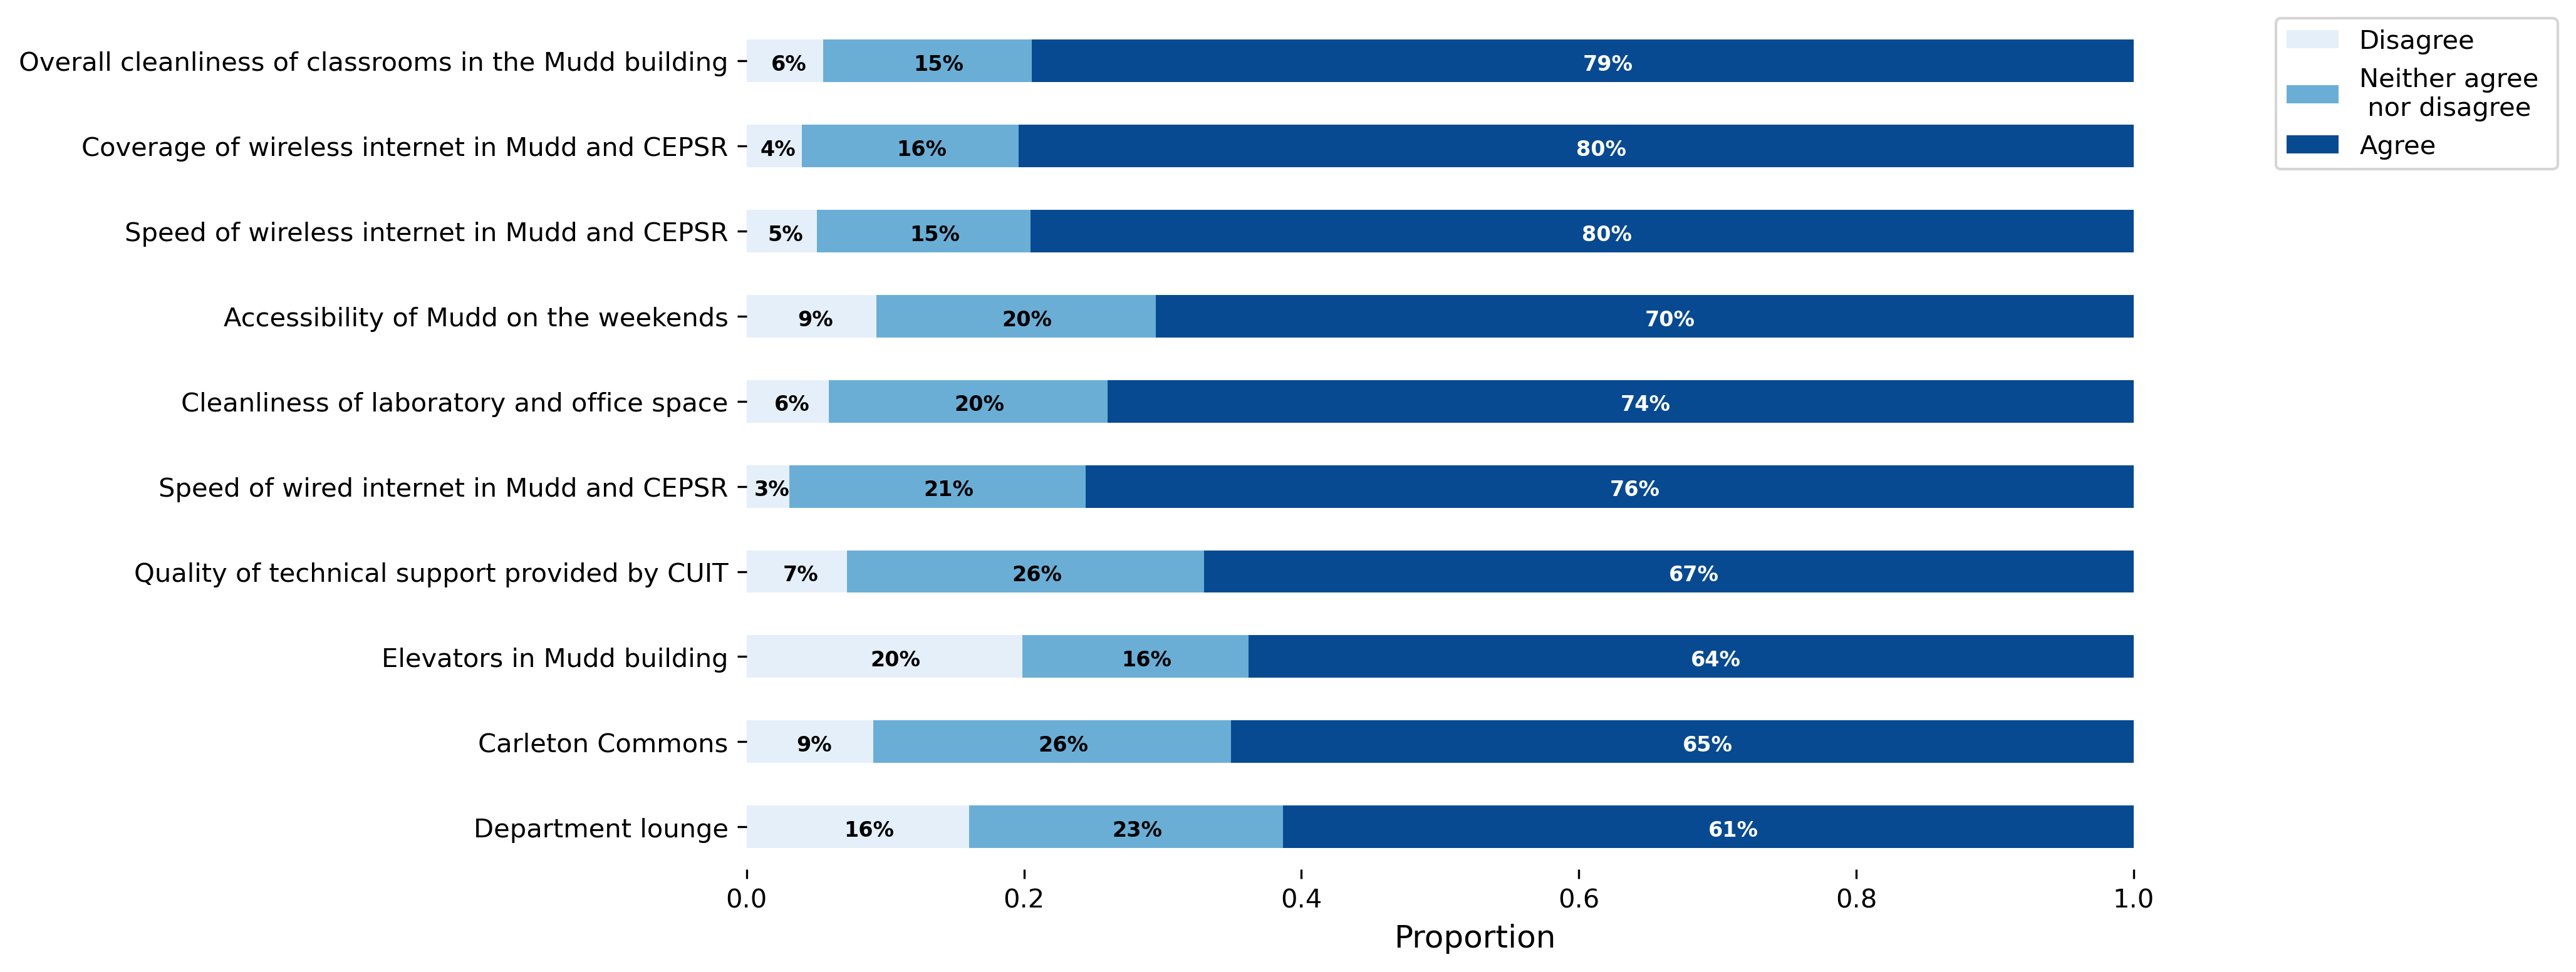

In [277]:
fig,ax=plt.subplots(figsize=(8,6),dpi=300)
bbb.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind3[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
            
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## Career Development

Are you currently looking for a job or plan to look for one in the near future?

In [134]:
lookingforjob=query_data(Q,qq,cleaned_data,"looking for a job",indx=1)
lookingforjob.value_counts()

Are you currently looking for a job or plan to look for one in the near future?


Response.10
Yes            928
No             264
Not Sure        79
dtype: int64

The following resources have been/were useful in aiding my job search:

In [135]:
jobres=query_data(Q,qq,cleaned_data,"job search",indx=1)
jobres['looking']=lookingforjob
jobres

The following resources have been/were useful in aiding my job search:


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1753426361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobres['looking']=lookingforjob


Alumni networking events Personal contacts Faculty  \
0                           3                 3       4   
2                           4                 2       2   
5                           2                 4       4   
6                           3                 3       2   
7                           3                 3       2   
...                       ...               ...     ...   
1585                        3                 4       2   
1586                        5                 5       5   
1587                        2                 4       3   
1588                        3                 4       4   
1590                        1                 1       1   

     Department administration/Career placement officer  \
0                                                     4   
2                                                     4   
5                                                     4   
6                                                     3   
7                                                     4   
...                                                 ...   
1585                                                  3   
1586                                                  5   
1587                                                  1   
1588                                                  4   
1590                                                  1   

     EGSC career related events Department-sponsored career events  \
0                             4                                  4   
2                             3                                  2   
5                             2                                  2   
6                             3                                  3   
7                             2                                  2   
...                         ...                                ...   
1585                          3                                  3   
1586                          5                                  5   
1587                          4                                  1   
1588                          4                                  4   
1590                          1                                  1   

     Company Information Sessions looking  
0                               4     Yes  
2                               2     Yes  
5                               2      No  
6                               3     Yes  
7                               3     Yes  
...                           ...     ...  
1585                            2      No  
1586                            5     Yes  
1587                            4     Yes  
1588                            3     Yes  
1590                            1     Yes  

[1271 rows x 8 columns]

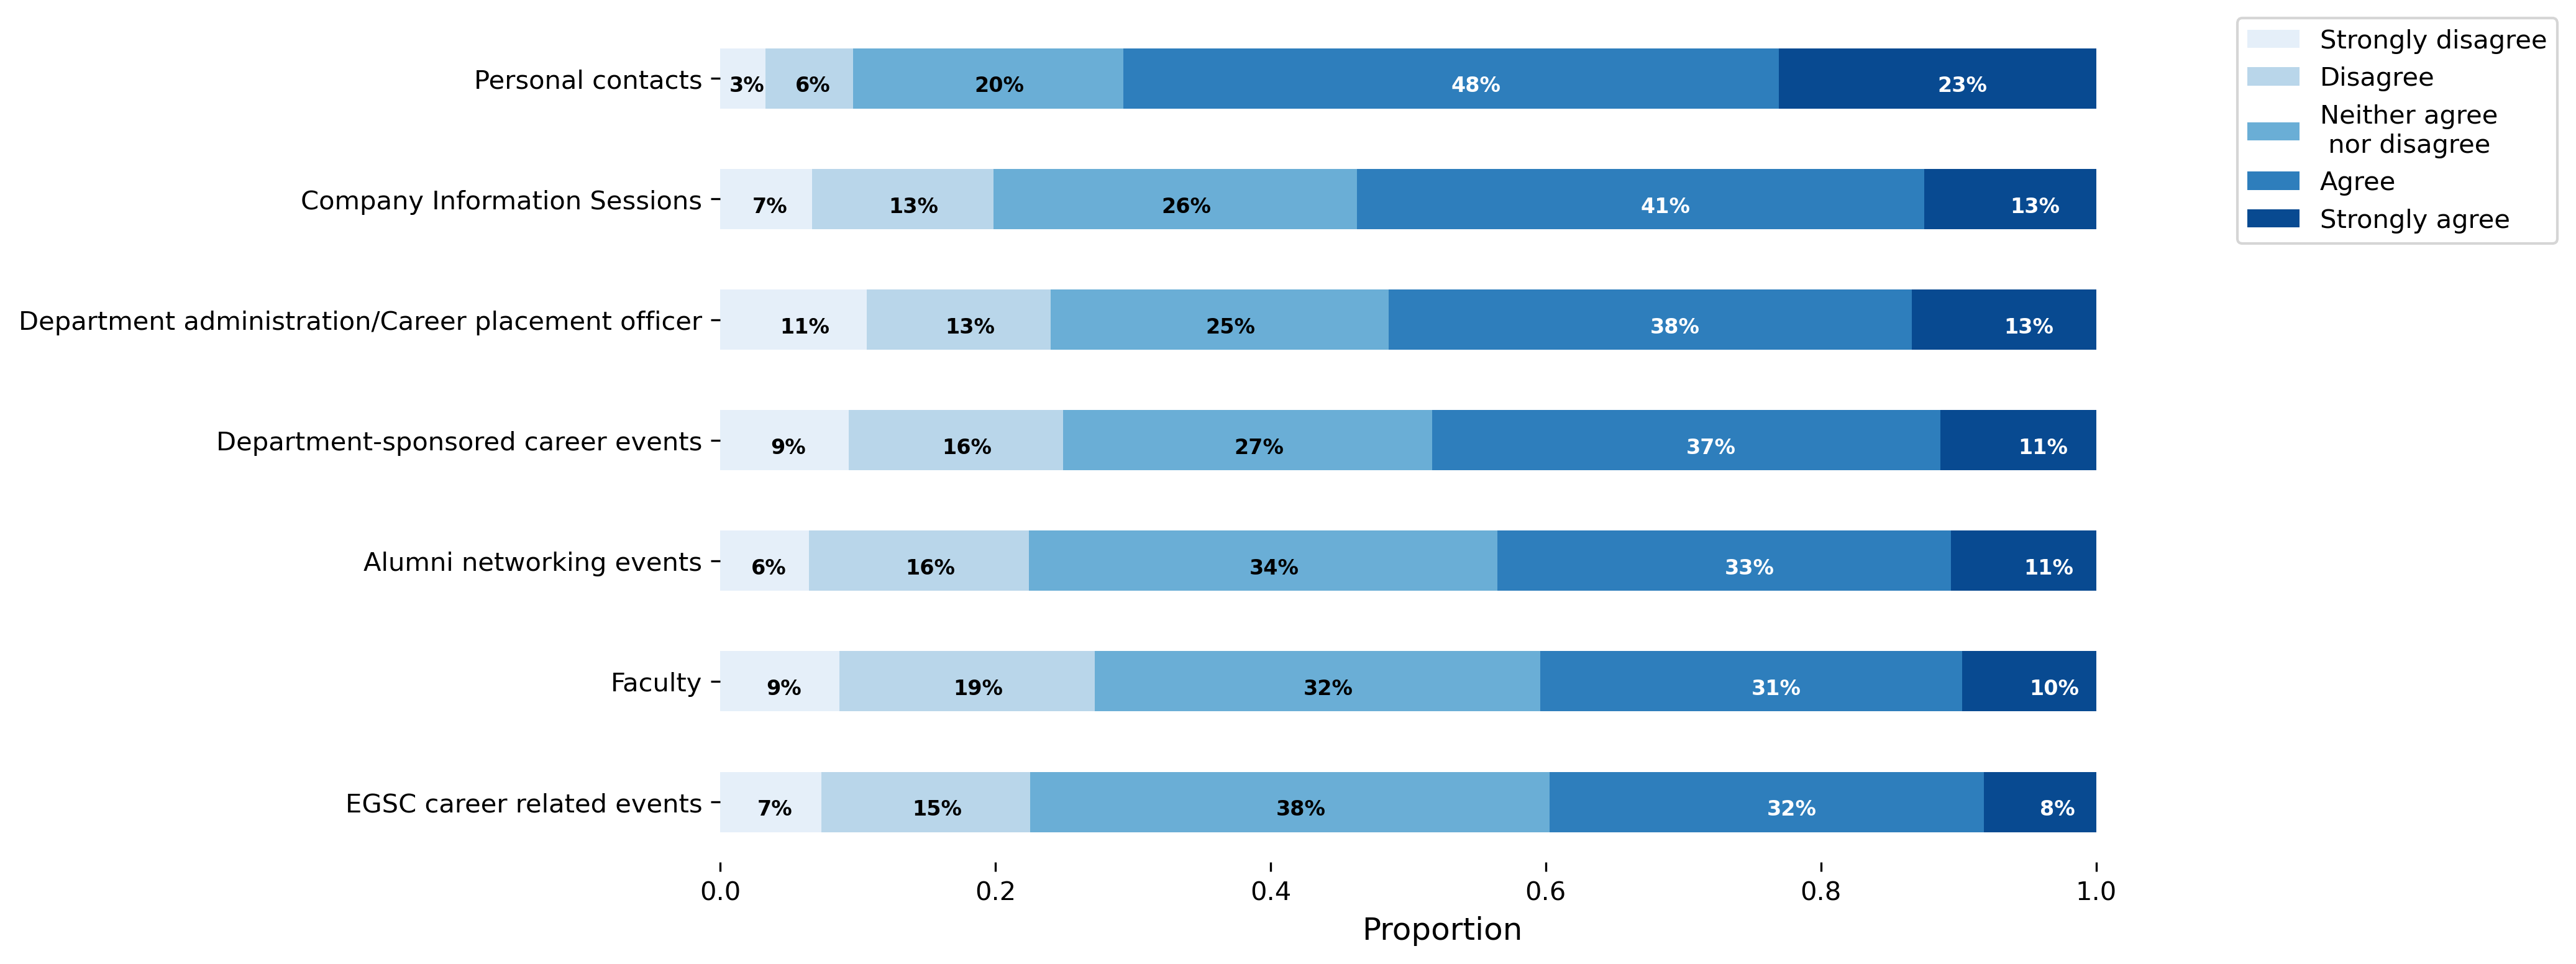

In [148]:

inddd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Unaware of this resource']

lokres=jobres[jobres['looking']!="No"].drop(columns="looking")
lokres_count=lokres.apply(pd.value_counts,axis=0)
d_=lokres_count[(lokres_count.iloc[3:,:].sum()).sort_values().index]
b_prob=d_.apply(lambda x: x / x.sum(), axis=0)
aaa=d_.T
bbb=b_prob.T


fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

GCP Website  GCP Employer Events  Spring Employer Expo  Career Workshops  \
1     0.105263             0.099305              0.113208          0.093347   
2     0.159881             0.140020              0.147964          0.137041   
3     0.438928             0.429990              0.378352          0.391261   
4     0.247269             0.269116              0.282026          0.309831   
5     0.048659             0.061569              0.078451          0.068520   

   Weekly Newsletters  Mock Interviews  Quick Questions or Walk-in hours  \
1            0.090367         0.076465                          0.079444   
2            0.144985         0.093347                          0.097319   
3            0.386296         0.436941                          0.425025   
4            0.297915         0.319762                          0.318769   
5            0.080437         0.073486                          0.079444   

   Individual Counseling Sessions  Career Fairs  Career Placement Officers  \
1                        0.085402      0.124131                   0.104270   
2                        0.117180      0.147964                   0.134062   
3                        0.398213      0.291956                   0.323734   
4                        0.303873      0.341609                   0.327706   
5                        0.095333      0.094340                   0.110228   

      VMock  
1  0.116187  
2  0.131082  
3  0.247269  
4  0.366435  
5  0.139027

The following Graduate Career Placement (GCP) resources have been/were useful in my job search and application process.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/775756620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcpres['looking']=lookingforjob


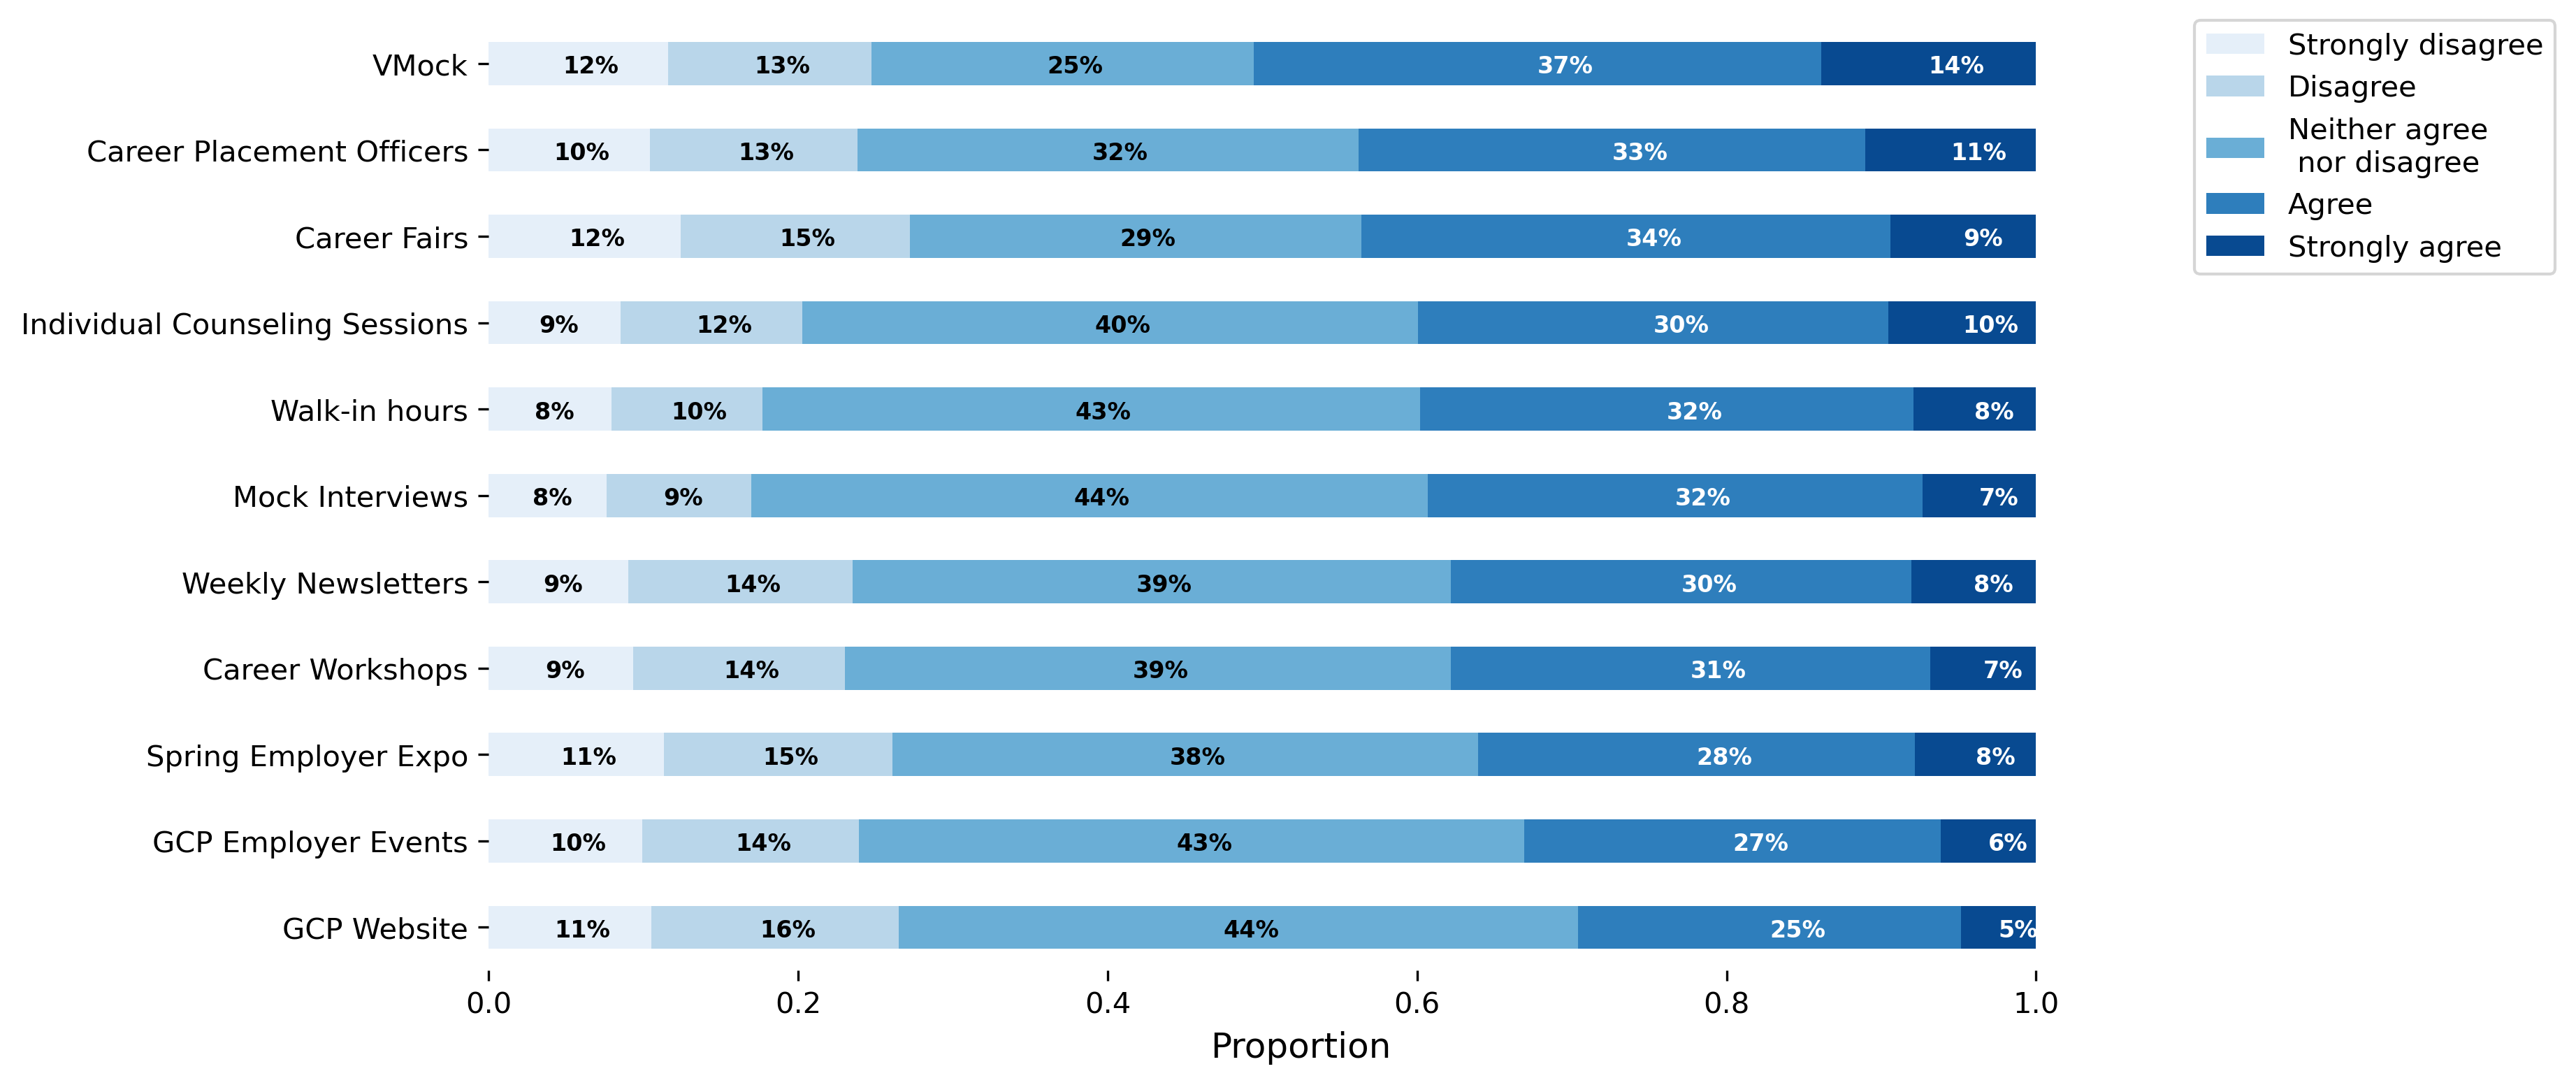

In [144]:
gcpres=query_data(Q,qq,cleaned_data,"job search",indx=2)
gcpres['looking']=lookingforjob
lokgcp=gcpres[gcpres['looking']!="No"].drop(columns="looking")

lokgcp_count=lokgcp.apply(pd.value_counts,axis=0)
lokgcp_count.rename(columns={'Quick Questions or Walk-in hours':'Walk-in hours'},inplace=True)
d_=lokgcp_count[(lokgcp_count.iloc[3:,:].sum()).sort_values().index]
b_prob=d_.apply(lambda x: x / x.sum(), axis=0)
aaa=d_.T
bbb=b_prob.T

cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


fig,ax=plt.subplots(figsize=(8,8),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

Are you currently looking for a job or plan to look for one in the near future?

In [1020]:
query_data(Q,qq,cleaned_data,"internship",indx=1).value_counts()

Have you secured a job offer or internship?


Response.14                          
No                                       544
Yes                                      479
I am not actively searching for a job    248
dtype: int64

In [968]:
intern=1271-query_data(Q,qq,cleaned_data,"secured",indx=2).isna().sum()

Which of the following have you secured?


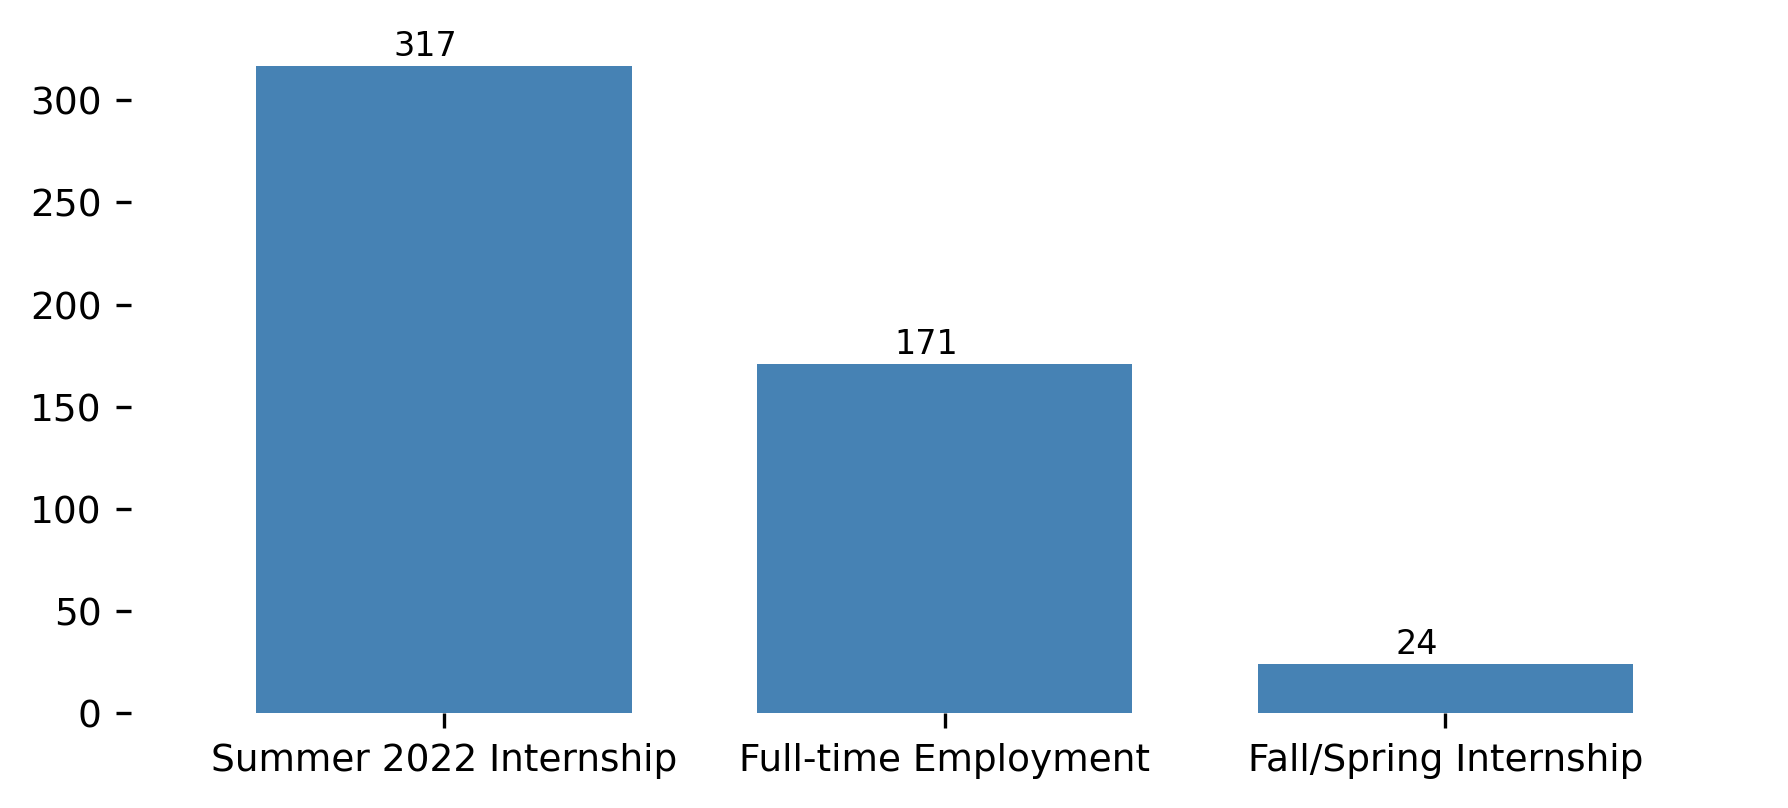

In [1006]:
fig,ax=plt.subplots(figsize=(7,3),dpi=300)
intern=pd.DataFrame(intern)
ax=intern.plot.bar(ax=ax,color="steelblue",width=0.75, rot=0 ,fontsize=9,legend=None)
#ax.set_xticklabels(indd, rotation=0,)
x_offset = -0.1
y_offset = 5
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(b.y1 + b.y0)        
    ax.annotate(int(b.y1 + b.y0), ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [1027]:
query_data(Q,qq,cleaned_data,"job opening",indx=1)['Response.15'].value_counts()

Where did you find out about this job opening?


Company website                                                       144
LinkedIn                                                              129
Personal contacts and/or friends                                       79
Other (please specify)                                                 49
GCP (including VMock)                                                  23
Career fairs/Employer Expo Events                                      21
Advisor                                                                13
Career Placement Officers                                              13
Faculty                                                                 7
Department administration                                               4
Engineering Graduate Student Council (EGSC)/SEAS networking events      1
Name: Response.15, dtype: int64

In [1017]:
jobfind=query_data(Q,qq,cleaned_data,"job opening",indx=1)
lokint=query_data(Q,qq,cleaned_data,"internship",indx=1)
jobfind["Yes"]=lokint

Where did you find out about this job opening?
Have you secured a job offer or internship?


In [1025]:

jobfind[jobfind.Yes=="I am not actively searching for a job"]['Response.15'].dropna()
#jobfind[jobfind.Yes=="No"]['Response.15'].dropna()

81     Personal contacts and/or friends
144              Other (please specify)
Name: Response.15, dtype: object

Have you secured a job offer or internship?
Which of the following have you secured?

Where did you find out about this job opening?
